In [106]:
import numpy as np

import sys
sys.path.append("/home/mayajas/Documents/programs/prfpy-main")

from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, DoG_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, DoG_Iso2DGaussianFitter

import os
from os.path import join as opj
import scipy.io

import nibabel as nib

import matplotlib.pyplot as plt

import nilearn
from nilearn import plotting, datasets, image
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_roi

import pickle
import pandas as pd

import itertools

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures

import random

from scipy import stats

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from transformations import quaternion_from_matrix, euler_from_quaternion

import nipype.interfaces.fsl as fsl

# import glob
import math 

from scipy.spatial import KDTree


import numpy.matlib

import seaborn as sb



In [107]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install seaborn

#### General directories and settings

In [108]:
subject_list = ['sub-01','sub-02','sub-03','sub-04']
hem_list     = ['lh','rh']
roi_list     = ['V1','V2','V3']
layer_space  = 'anat'
prf_model    = 'prfpy_Iso2DGaussianModel'
prf_model    = 'prfpy_Iso2DGaussianModel_LinearDeveining'


proj_dir     = '/home/mayajas/scratch/project-00-7t-pipeline-dev/'
prfpy_dir    = '/home/mayajas/scratch/project-00-7t-pipeline-dev/output/'+prf_model+'/'

report_dir   = '/home/mayajas/Documents/project-00-7t-pipeline-dev/reports/figures'

# dataframe outputs of pRF_getSigmaAcrossDepth.py
if layer_space == 'func':
    df_layers_fn = opj(prfpy_dir,'df_layers_allROI_func')
else:
    df_layers_fn = opj(prfpy_dir,'df_layers_allROI')


In [109]:
screen_size_cm     = 12.0
screen_distance_cm = 52.0
TR                 = 3.0
#design_matrix      = mat["stim"]

max_ecc = math.atan(screen_size_cm/screen_distance_cm)/2
max_ecc_deg = math.degrees(max_ecc)

print("Max eccentricity of stimulus is "+str(round(max_ecc_deg,2)))

Max eccentricity of stimulus is 6.5


#### Useful functions

In [110]:
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)], abs(data - np.mean(data)) < m * np.std(data)

In [111]:
def reject_outliers_median(data, m=3.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m], s < m

In [112]:
def flatten(l):
    return [item for sublist in l for item in sublist]

# PRF size across cortical depth: all subjects

## Load data

In [113]:
f = open(df_layers_fn,'rb')
df_equivol_per_depth, \
df_equivol_per_depth_ecc2, \
df_equidist_per_depth, \
df_equidist_per_depth_ecc2, \
df_pRF_per_cortdist, \
df_pRF_per_cortdist_ecc2 = pickle.load(f)

f.close()

In [89]:
df_equivol_per_depth.head()

sub id roi hem  depth                                           pRF size  \
0  sub-01  V1  lh    1.0  [0.5011069648695775, 0.40007228391200533, 0.41...   
1  sub-01  V1  lh    2.0  [0.4014067382530454, 0.4027635568549481, 0.411...   
2  sub-01  V1  lh    3.0  [0.5028093607754424, 1.3778713209473807, 0.372...   
3  sub-01  V1  lh    4.0  [0.4103991615151292, 1.0728341630828246, 1.362...   
4  sub-01  V1  lh    5.0  [0.40599301206943644, 0.41899280041739106, 0.8...   

                                                 ecc  \
0  [3.1560445432114492, 2.927794585574861, 1.1335...   
1  [0.7476031117501816, 1.5603951275927541, 6.579...   
2  [0.6923324559450494, 6.591971021608676, 0.9251...   
3  [3.7162537566340603, 0.11823975963706833, 3.68...   
4  [0.9353106961724557, 2.1428380467067485, 2.651...   

                                                 rsq  
0  [0.09949711349787904, 0.18063296239680593, 0.1...  
1  [0.05905815473194287, 0.043080920543032364, 0....  
2  [0.24479332504722995, 0.12554899960429722, 0.0...  
3  [0.08515955901376882, 0.1495453861604299, 0.08...  
4  [0.33907941925853236, 0.07551410760443167, 0.0...

In [90]:
df_equidist_per_depth.head()

sub id roi hem  depth                                           pRF size  \
0  sub-01  V1  lh    1.0  [0.5011069648695775, 0.40007228391200533, 0.41...   
1  sub-01  V1  lh    2.0  [0.41119937679885, 0.4110252350201856, 0.32644...   
2  sub-01  V1  lh    3.0  [1.3778713209473807, 0.39397682128063954, 0.50...   
3  sub-01  V1  lh    4.0  [1.0728341630828246, 0.7043548973343082, 0.502...   
4  sub-01  V1  lh    5.0  [0.40599301206943644, 0.41899280041739106, 0.7...   

                                                 ecc  \
0  [3.1560445432114492, 2.927794585574861, 1.1335...   
1  [6.5795980027226895, 1.102146332632887, 0.8522...   
2  [6.591971021608676, 1.2091919486770515, 0.6493...   
3  [0.11823975963706833, 1.3347729689462977, 0.69...   
4  [0.9353106961724557, 2.1428380467067485, 0.834...   

                                                 rsq  
0  [0.09949711349787904, 0.18063296239680593, 0.1...  
1  [0.11943411775830015, 0.1333012821436964, 0.08...  
2  [0.12554899960429722, 0.08112256585909694, 0.1...  
3  [0.1495453861604299, 0.13558468553964953, 0.24...  
4  [0.33907941925853236, 0.07551410760443167, 0.1...

In [91]:
df_pRF_per_cortdist.head()

sub id roi hem                                           pRF size  \
0  sub-01  V1  lh  [0.6995862165835947, 1.0788782490087125, 0.381...   
1  sub-01  V2  lh  [1.2195367062149134, 0.403460194562427, 0.8227...   
2  sub-01  V3  lh  [0.601084544240993, 1.3840549883832673, 0.4118...   
3  sub-01  V1  rh  [0.4111922485508004, 0.5954419581025879, 0.409...   
4  sub-01  V2  rh  [0.8245820868298239, 1.2283051204874245, 1.223...   

                                                 ecc  \
0  [1.3965025929669226, 6.584247833210548, 1.8458...   
1  [6.5804084761262605, 2.1432384223923617, 1.625...   
2  [5.795197146694691, 1.0081547473803154, 0.9695...   
3  [6.58667352631391, 1.6847943054930699, 2.62298...   
4  [0.8272515897144248, 2.1501640225712864, 6.582...   

                                                 rsq  \
0  [0.09367336613356936, 0.08574507358513117, 0.0...   
1  [0.10854078047264448, 0.06323345540758984, 0.0...   
2  [0.06684781733332179, 0.1966229873319677, 0.25...   
3  [0.06886632411105642, 0.08301480030843089, 0.1...   
4  [0.11428744693722115, 0.15193790572230692, 0.1...   

                                           cort dist  
0  [2.529822128134704, 2.2627416997969525, 2.2627...  
1  [2.2627416997969525, 2.2627416997969525, 2.400...  
2  [1.6, 1.6, 1.788854381999832, 0.8, 1.131370849...  
3  [-1.6, -1.6, -1.6, -1.1313708498984762, -1.385...  
4  [1.9595917942265424, 2.4000000000000004, 1.788...

In [92]:
df_pRF_per_cortdist_ecc2.head()

sub id roi hem                                           pRF size  \
0  sub-01  V1  lh  [0.6995862165835947, 1.0788782490087125, 0.381...   
1  sub-01  V2  lh  [1.2195367062149134, 0.8227160482385882, 0.411...   
2  sub-01  V3  lh  [1.3840549883832673, 0.4118978465600136, 0.937...   
3  sub-01  V1  rh  [0.4059388223182111, 0.9482074146532964, 0.411...   
4  sub-01  V2  rh  [0.5033425671926188, 0.501605011879007, 1.2269...   

                                                 ecc  \
0  [1.3965025929669226, 6.584247833210548, 1.8458...   
1  [6.5804084761262605, 1.6250280181019194, 6.580...   
2  [1.0081547473803154, 0.9695462588330056, 0.661...   
3  [2.125413388640813, 5.059917202026603, 6.58685...   
4  [0.2282230409813217, 0.4110093389866788, 0.381...   

                                                 rsq  \
0  [0.09367336613356936, 0.08574507358513117, 0.0...   
1  [0.10854078047264448, 0.09116691384733222, 0.0...   
2  [0.1966229873319677, 0.2588998310749342, 0.150...   
3  [0.07370363352955611, 0.14208801594737674, 0.0...   
4  [0.10792627386086495, 0.26305261722019635, 0.2...   

                                           cort dist  
0  [2.529822128134704, 2.2627416997969525, 2.2627...  
1  [2.2627416997969525, 2.4000000000000004, 1.959...  
2  [1.6, 1.788854381999832, 0.8, 1.13137084989847...  
3  [-0.8, -1.1313708498984762, -1.788854381999832...  
4  [1.1313708498984762, 1.788854381999832, 2.2627...

## Laynii layers: pRF per cortical layer fitted at target eccentricity

### Equidistant layering

#### pRF size as a function of eccentricity (separately for each cortical layer)
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Set number of layers, eccentricities, subjects, hemispheres

In [12]:
n_layers   = 6
n_sub      = len(subject_list)
n_hem      = len(hem_list)

Thresholds

In [13]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

In [14]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [15]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


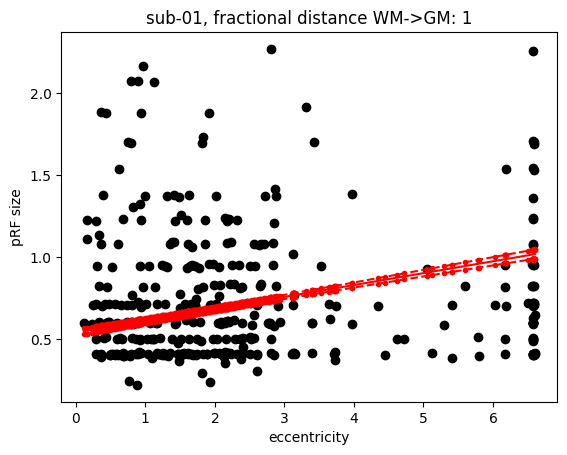

Intercept: 0.5391868353554152
t = 55.71, p = 0.00000
Slope: 0.07240938995591711
t = 23.19, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


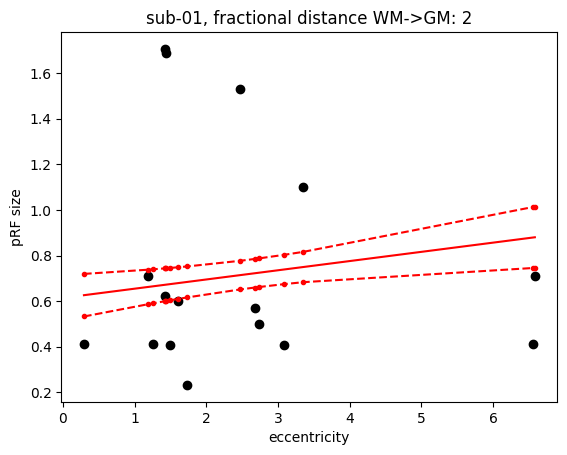

Intercept: 0.614151588049487
t = 12.03, p = 0.00000
Slope: 0.04038223483304594
t = 2.65, p = 0.00811
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


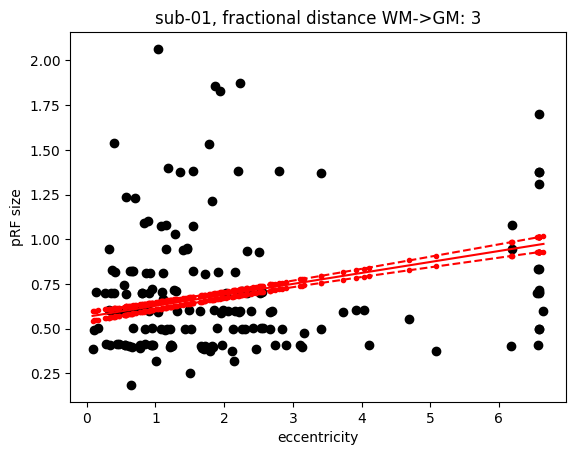

Intercept: 0.5668581519850168
t = 41.98, p = 0.00000
Slope: 0.061295626934586435
t = 13.46, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


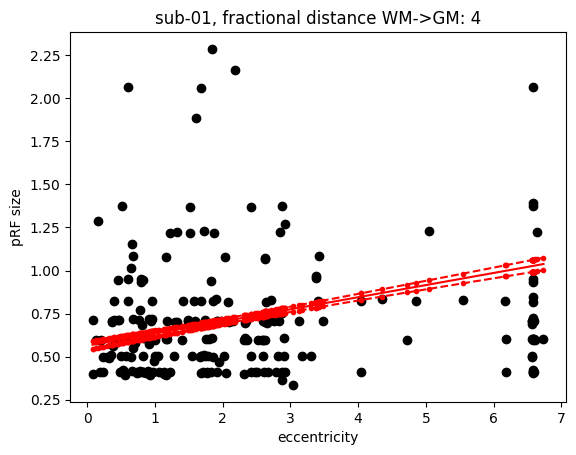

Intercept: 0.563059372399995
t = 48.76, p = 0.00000
Slope: 0.07042590223532434
t = 18.50, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


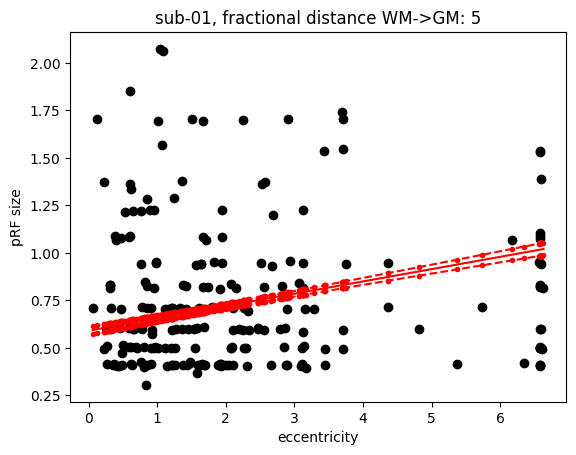

Intercept: 0.5908956045687133
t = 55.12, p = 0.00000
Slope: 0.06478824729292923
t = 18.23, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


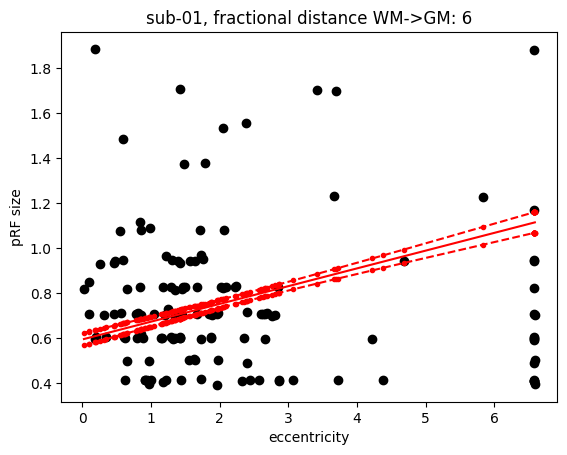

Intercept: 0.5940113925198209
t = 41.24, p = 0.00000
Slope: 0.0790129588864629
t = 15.93, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


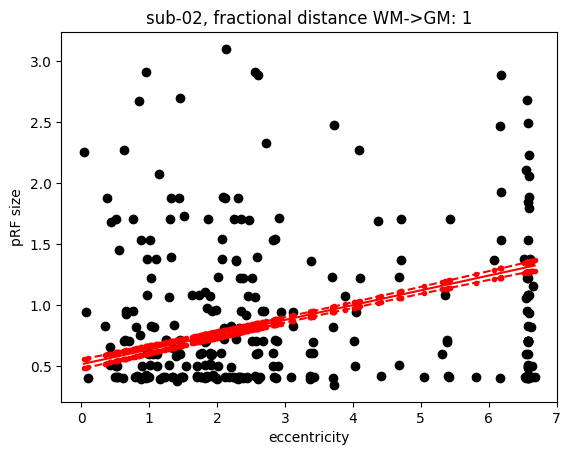

Intercept: 0.513289686092165
t = 26.12, p = 0.00000
Slope: 0.12124478012570533
t = 23.65, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


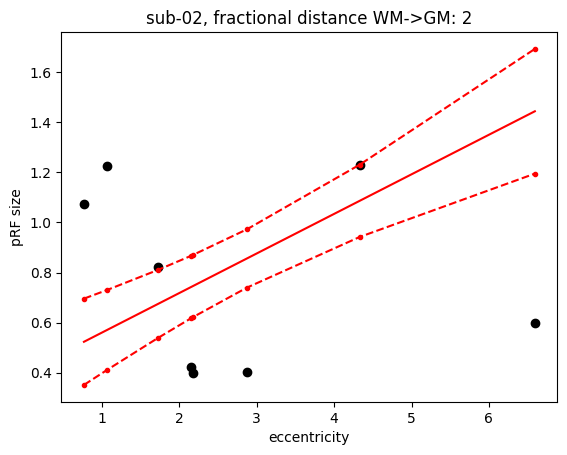

Intercept: 0.4024088137763369
t = 3.79, p = 0.00015
Slope: 0.1579628679406019
t = 5.20, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


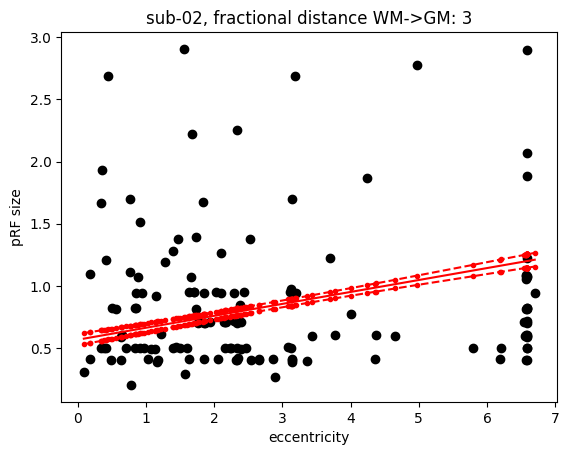

Intercept: 0.5666996968931822
t = 24.35, p = 0.00000
Slope: 0.09607351651969909
t = 14.92, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


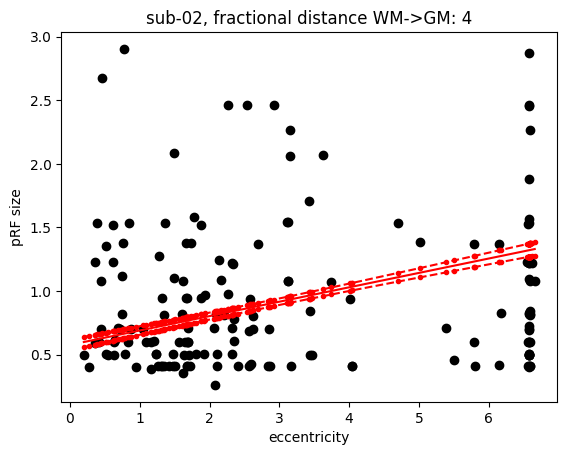

Intercept: 0.5767103959610766
t = 26.61, p = 0.00000
Slope: 0.1131605747369814
t = 18.46, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


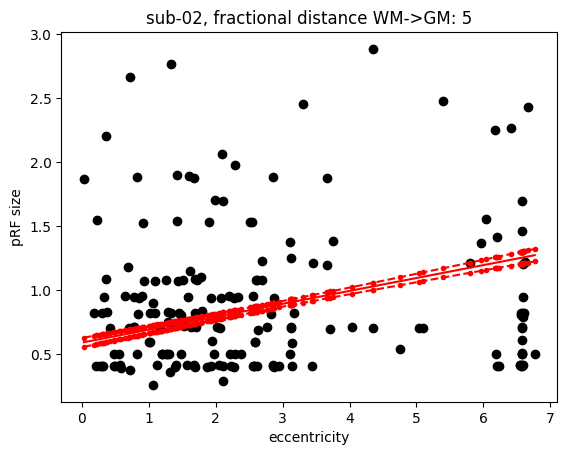

Intercept: 0.5909609787824893
t = 31.88, p = 0.00000
Slope: 0.10101854022914725
t = 18.53, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


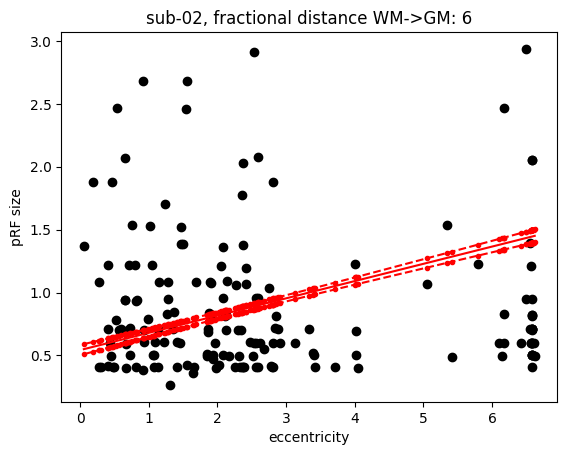

Intercept: 0.5426720234813178
t = 26.17, p = 0.00000
Slope: 0.1371374517949948
t = 22.84, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


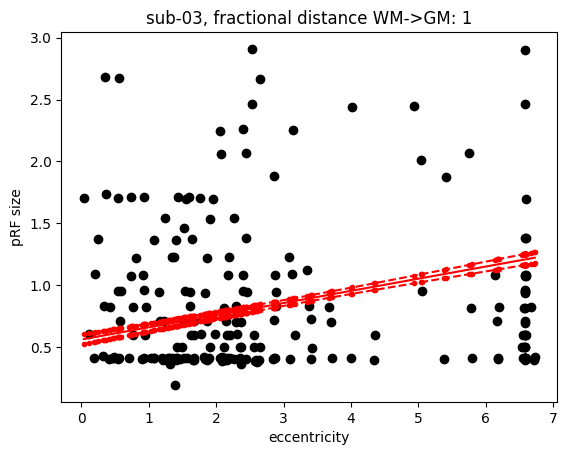

Intercept: 0.5596342117158808
t = 27.72, p = 0.00000
Slope: 0.09836175791810944
t = 18.11, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


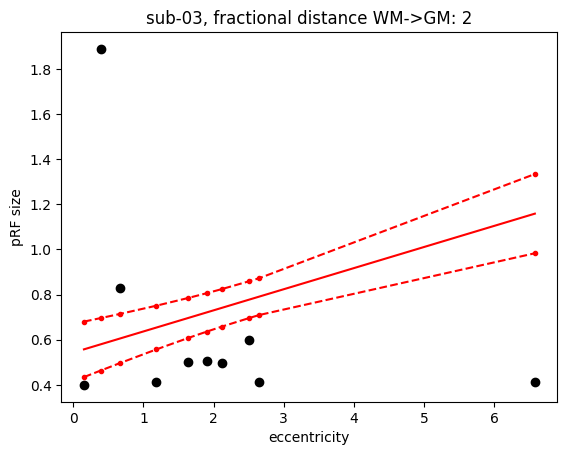

Intercept: 0.5431655894436724
t = 8.36, p = 0.00000
Slope: 0.09356061979641041
t = 4.76, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


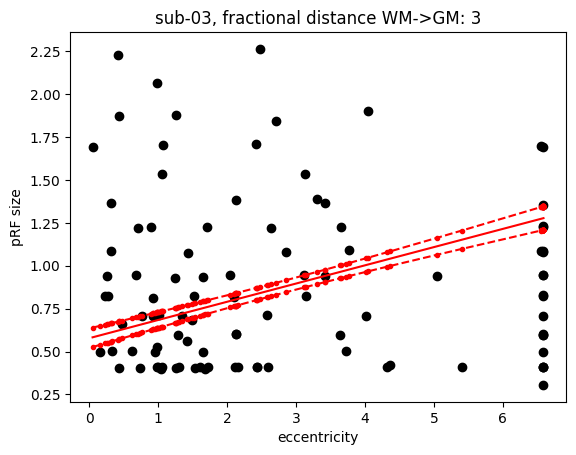

Intercept: 0.5777853681337509
t = 19.78, p = 0.00000
Slope: 0.10615474506892564
t = 13.12, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


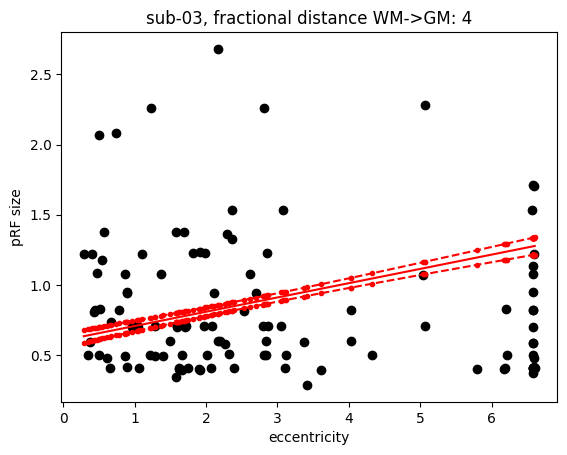

Intercept: 0.6059211382033971
t = 24.55, p = 0.00000
Slope: 0.10178950608721149
t = 14.27, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


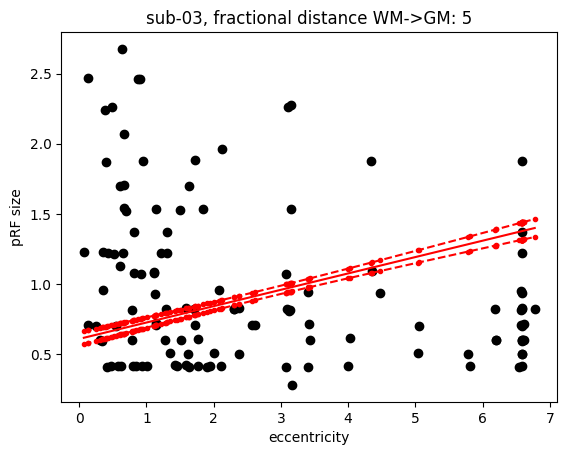

Intercept: 0.6071642101189748
t = 25.63, p = 0.00000
Slope: 0.1168382354640621
t = 16.59, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


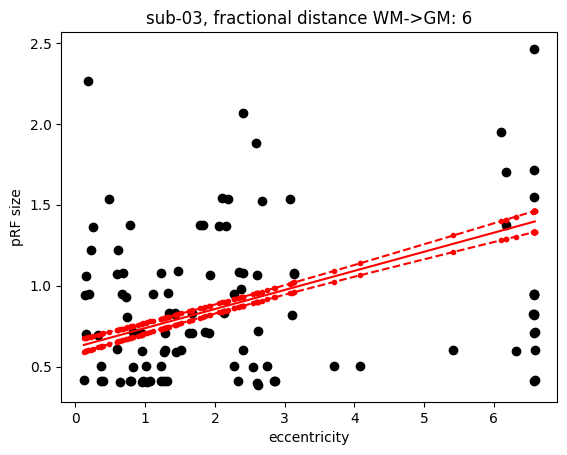

Intercept: 0.6192506768668967
t = 28.75, p = 0.00000
Slope: 0.11802416705699167
t = 16.81, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


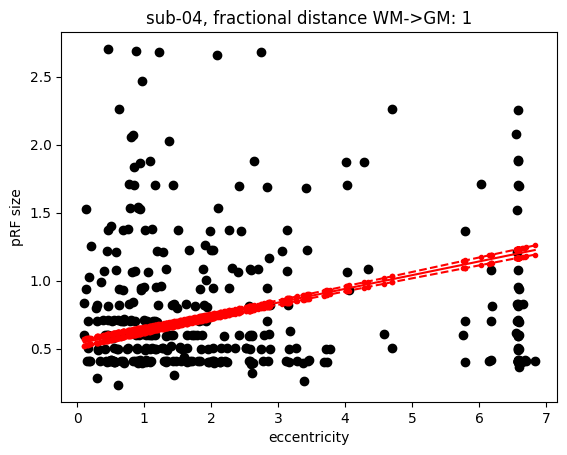

Intercept: 0.5368924656513011
t = 41.75, p = 0.00000
Slope: 0.10079732288117951
t = 27.26, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


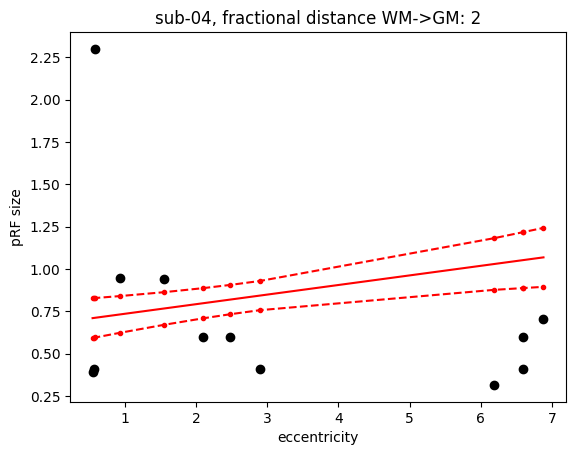

Intercept: 0.6787282819531976
t = 10.07, p = 0.00000
Slope: 0.056682221328853116
t = 3.04, p = 0.00238
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


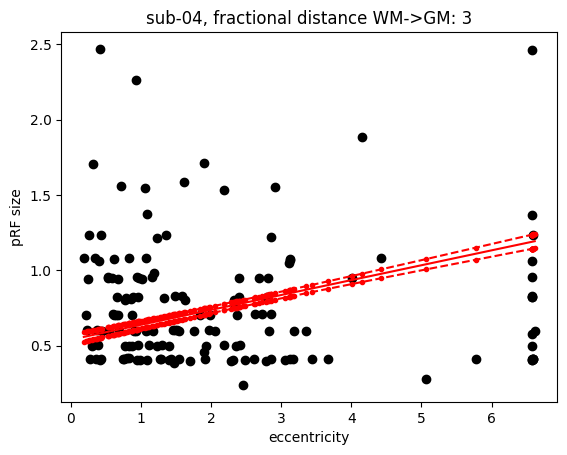

Intercept: 0.5402502598115642
t = 32.31, p = 0.00000
Slope: 0.09868543760126414
t = 19.09, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


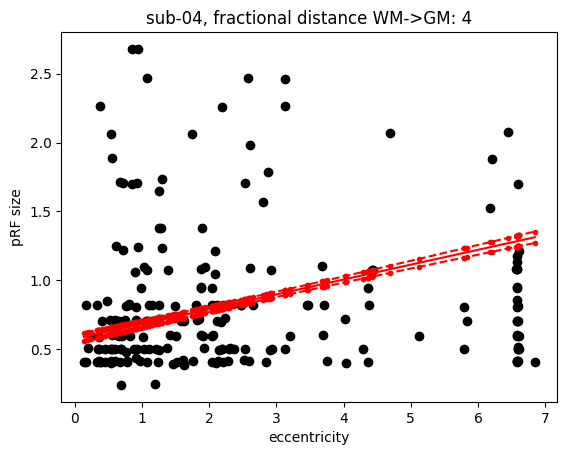

Intercept: 0.5740389264238968
t = 38.36, p = 0.00000
Slope: 0.10793140488695106
t = 24.40, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


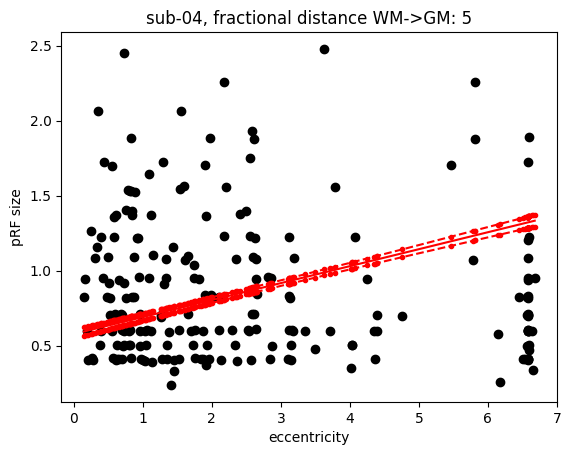

Intercept: 0.5768468813286579
t = 39.34, p = 0.00000
Slope: 0.11312862023361829
t = 25.94, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


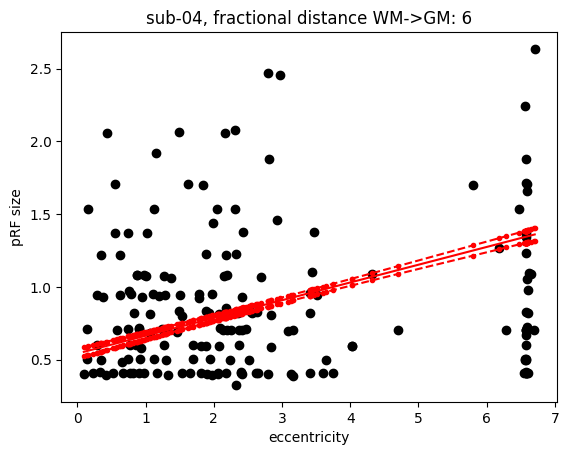

Intercept: 0.5426649340055844
t = 33.74, p = 0.00000
Slope: 0.12195580269138602
t = 25.64, p = 0.00000


In [16]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equidist_per_depth.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth['roi'] == 'V1') & 
                                    (df_equidist_per_depth['hem'] == 'lh') & 
                                    (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equidist_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equidist_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equidist_per_depth.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth['roi'] == 'V1') & 
                                    (df_equidist_per_depth['hem'] == 'rh') & 
                                    (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equidist_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equidist_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
#         # bin eccentricity data
#         bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
#         x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equidist.loc[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equidist.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope

    #     # print the quantiles
    #     print("95% quantiles:")
    #     print(quantiles.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

    #     # print the median
    #     print("Median:")
    #     print(median.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

        # save stats to df
        idx=df_pRFxecc_stats_equidist.loc[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_equidist.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        df_pRFxecc_stats_equidist.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])

        df_pRFxecc_stats_equidist.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        df_pRFxecc_stats_equidist.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])

        df_pRFxecc_stats_equidist.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        
    

TODO: eccentricity bins and take avg pRF size in each bin, compute linear regression to these points, bootstrapping

In [17]:
df_pRFxecc_stats_equidist


sub id  depth  intercept     slope         intercept-stats  \
0   sub-01    1.0   0.539187  0.072409  t = 55.71, p = 0.00000   
1   sub-01    2.0   0.614152  0.040382  t = 12.03, p = 0.00000   
2   sub-01    3.0   0.566858  0.061296  t = 41.98, p = 0.00000   
3   sub-01    4.0   0.563059  0.070426  t = 48.76, p = 0.00000   
4   sub-01    5.0   0.590896  0.064788  t = 55.12, p = 0.00000   
5   sub-01    6.0   0.594011  0.079013  t = 41.24, p = 0.00000   
6   sub-02    1.0   0.513290  0.121245  t = 26.12, p = 0.00000   
7   sub-02    2.0   0.402409  0.157963   t = 3.79, p = 0.00015   
8   sub-02    3.0   0.566700  0.096074  t = 24.35, p = 0.00000   
9   sub-02    4.0   0.576710  0.113161  t = 26.61, p = 0.00000   
10  sub-02    5.0   0.590961  0.101019  t = 31.88, p = 0.00000   
11  sub-02    6.0   0.542672  0.137137  t = 26.17, p = 0.00000   
12  sub-03    1.0   0.559634  0.098362  t = 27.72, p = 0.00000   
13  sub-03    2.0   0.543166  0.093561   t = 8.36, p = 0.00000   
14  sub-03    3.0   0.577785  0.106155  t = 19.78, p = 0.00000   
15  sub-03    4.0   0.605921  0.101790  t = 24.55, p = 0.00000   
16  sub-03    5.0   0.607164  0.116838  t = 25.63, p = 0.00000   
17  sub-03    6.0   0.619251  0.118024  t = 28.75, p = 0.00000   
18  sub-04    1.0   0.536892  0.100797  t = 41.75, p = 0.00000   
19  sub-04    2.0   0.678728  0.056682  t = 10.07, p = 0.00000   
20  sub-04    3.0   0.540250  0.098685  t = 32.31, p = 0.00000   
21  sub-04    4.0   0.574039  0.107931  t = 38.36, p = 0.00000   
22  sub-04    5.0   0.576847  0.113129  t = 39.34, p = 0.00000   
23  sub-04    6.0   0.542665  0.121956  t = 33.74, p = 0.00000   

               slope-stats  pRF@2deg  
0   t = 23.19, p = 0.00000  0.684006  
1    t = 2.65, p = 0.00811  0.694916  
2   t = 13.46, p = 0.00000  0.689449  
3   t = 18.50, p = 0.00000  0.703911  
4   t = 18.23, p = 0.00000  0.720472  
5   t = 15.93, p = 0.00000  0.752037  
6   t = 23.65, p = 0.00000  0.755779  
7    t = 5.20, p = 0.00000  0.718335  
8   t = 14.92, p = 0.00000  0.758847  
9   t = 18.46, p = 0.00000  0.803032  
10  t = 18.53, p = 0.00000  0.792998  
11  t = 22.84, p = 0.00000  0.816947  
12  t = 18.11, p = 0.00000  0.756358  
13   t = 4.76, p = 0.00000  0.730287  
14  t = 13.12, p = 0.00000  0.790095  
15  t = 14.27, p = 0.00000  0.809500  
16  t = 16.59, p = 0.00000  0.840841  
17  t = 16.81, p = 0.00000  0.855299  
18  t = 27.26, p = 0.00000  0.738487  
19   t = 3.04, p = 0.00238  0.792093  
20  t = 19.09, p = 0.00000  0.737621  
21  t = 24.40, p = 0.00000  0.789902  
22  t = 25.94, p = 0.00000  0.803104  
23  t = 25.64, p = 0.00000  0.786577

#### Plot estimated pRF size at target eccentricity

[ 0.00341757 -0.01160049  0.6962338 ]
R2 quadratic: 0.9663973246284402
R2 linear: 0.8301705507292261
[0.00187116 0.00330225 0.73438566]
R2 quadratic: 0.7212077516814878
R2 linear: 0.7017210557577143
[0.00158529 0.01306793 0.72728191]
R2 quadratic: 0.8869649157298606
R2 linear: 0.8788955259221884
[-0.00142804  0.01930374  0.72872602]
R2 quadratic: 0.3820263462206357
R2 linear: 0.36375854315087497


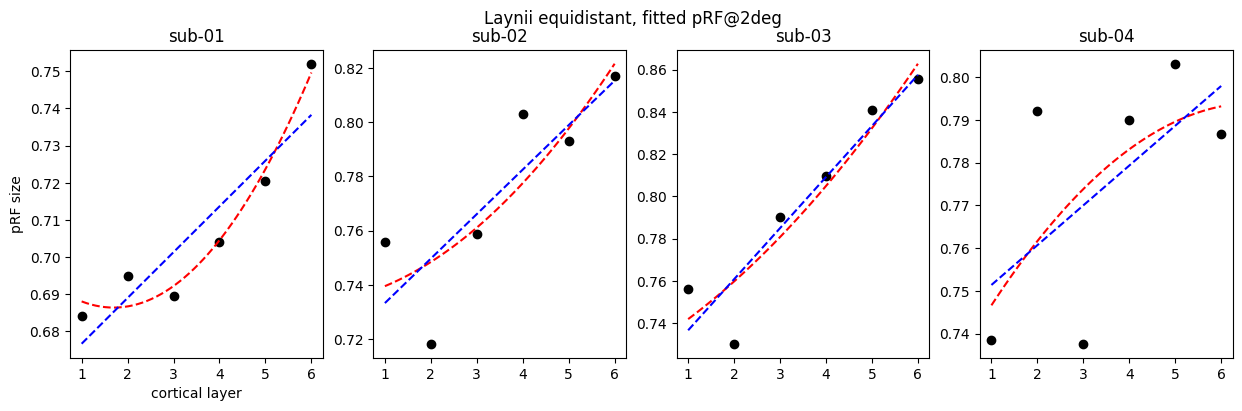

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equidist.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 
#     axs[sub_id].set_ylim([0.65, 0.95])
#     axs[sub_id].set_yticks(np.linspace(0.65,0.95,4)) 
    
plt.suptitle('Laynii equidistant, fitted pRF@2deg')
plt.show()
    
#     axs[sub_id].set_ylim([0.7, 1.1]4
#     axs[sub_id].set_yticks(np.linspace(0.7,1.1,5))    
    
#     df_pRFxecc_stats_equidist.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

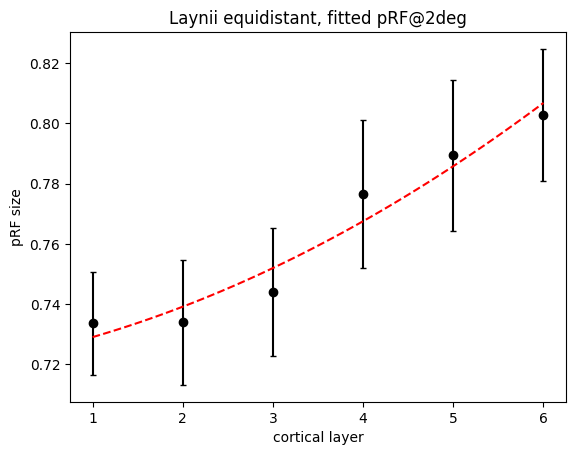

In [19]:
idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equidist.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equidist['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_equidist.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equidist.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Laynii equidistant, fitted pRF@2deg')
plt.show()


### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Extract lh and rh sigma and ecc values at chosen rsq threshold

In [20]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

Create a dataframe to save intercept and slope stats

In [21]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


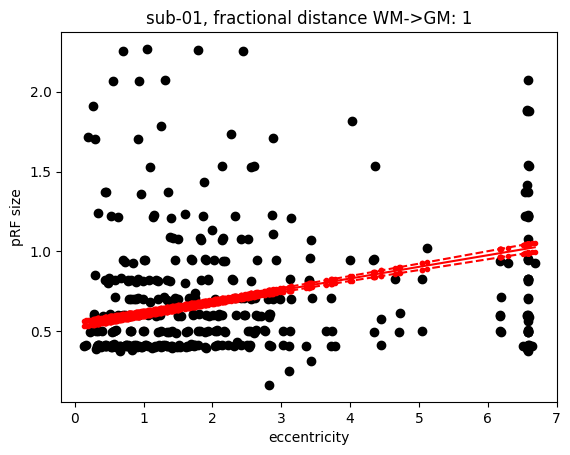

Intercept: 0.5392621575521586
t = 55.76, p = 0.00000
Slope: 0.07286801262750633
t = 23.31, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


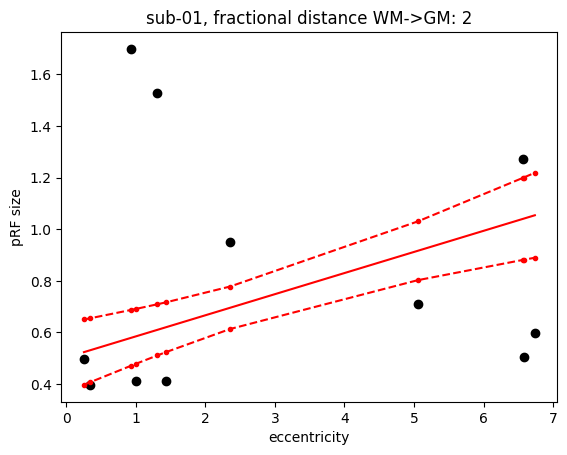

Intercept: 0.5027046092466941
t = 7.35, p = 0.00000
Slope: 0.0818275382549885
t = 4.30, p = 0.00002
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


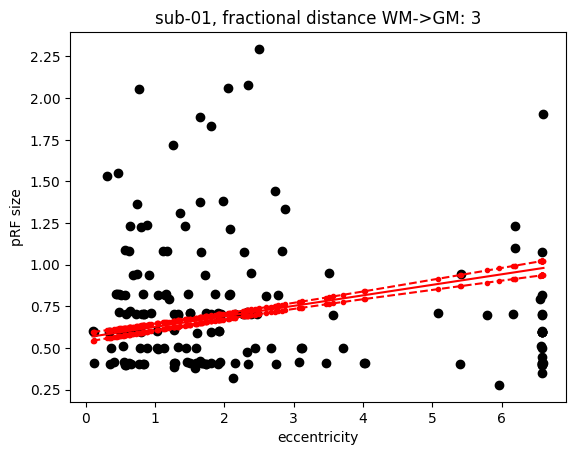

Intercept: 0.5635216433924057
t = 41.41, p = 0.00000
Slope: 0.06321485346159508
t = 13.60, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


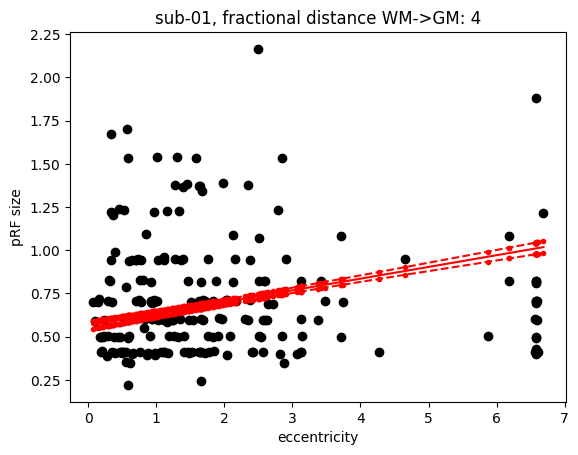

Intercept: 0.564354425336308
t = 49.81, p = 0.00000
Slope: 0.06786140272013189
t = 18.34, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


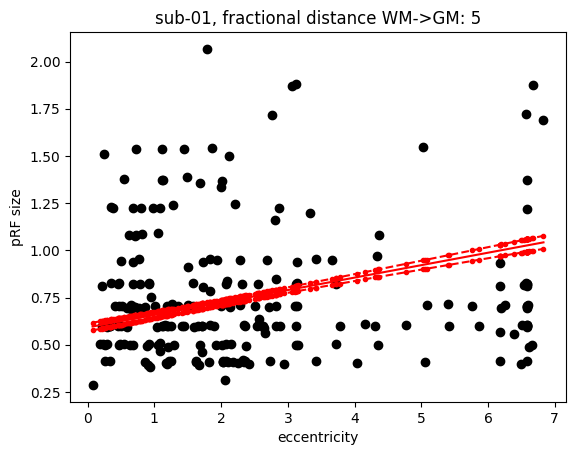

Intercept: 0.5914694413854245
t = 55.65, p = 0.00000
Slope: 0.06597322599629551
t = 18.53, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


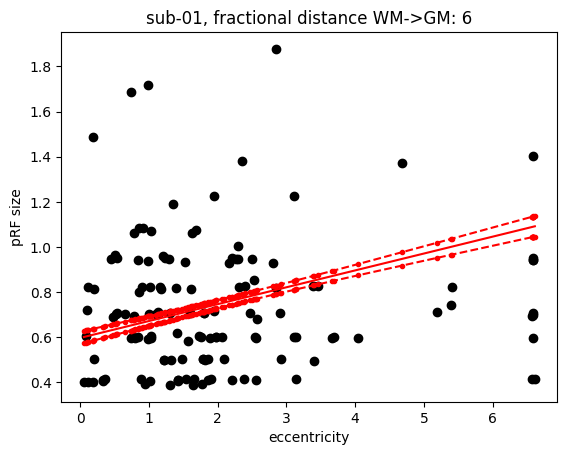

Intercept: 0.5966939842534866
t = 42.32, p = 0.00000
Slope: 0.07482427143947547
t = 15.38, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


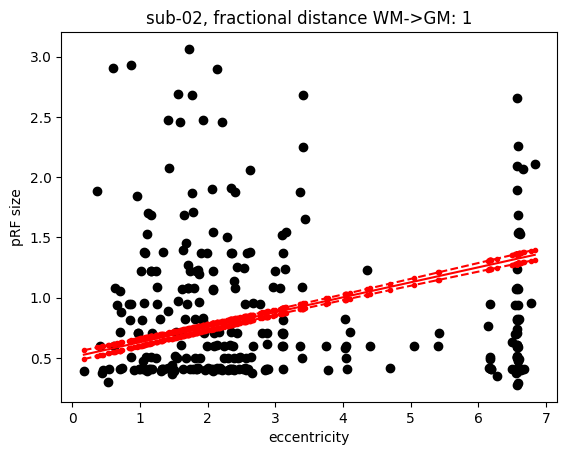

Intercept: 0.5051757590363182
t = 25.82, p = 0.00000
Slope: 0.12436771174309469
t = 24.46, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


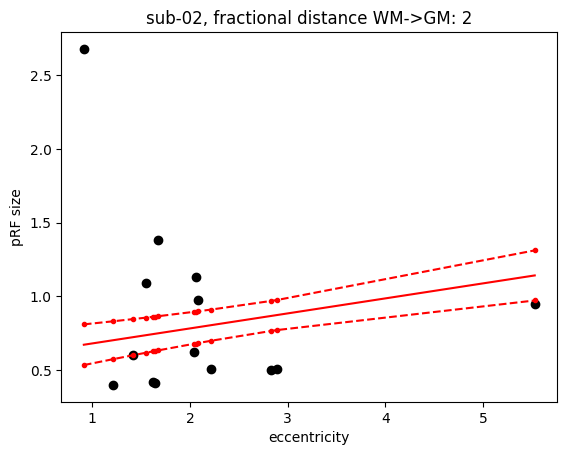

Intercept: 0.5778814236803064
t = 6.59, p = 0.00000
Slope: 0.10189164308483536
t = 4.02, p = 0.00006
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


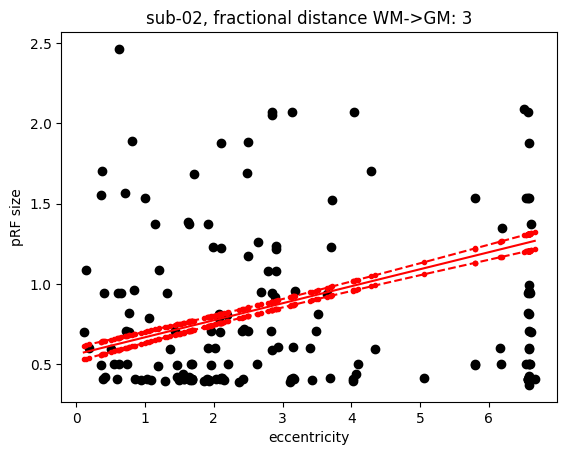

Intercept: 0.5633906165662453
t = 25.31, p = 0.00000
Slope: 0.10580866233592423
t = 16.91, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


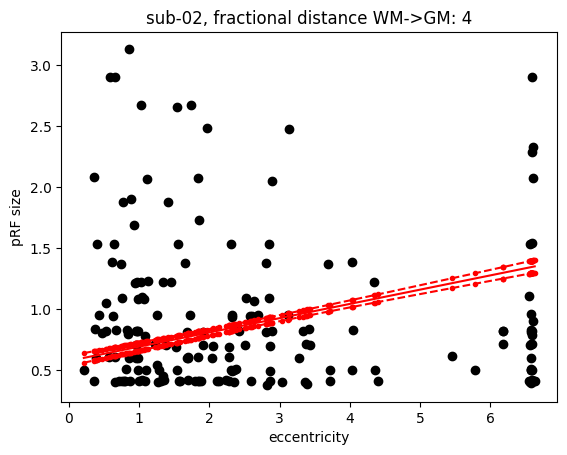

Intercept: 0.5736709738892658
t = 27.19, p = 0.00000
Slope: 0.11703768742869475
t = 19.43, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


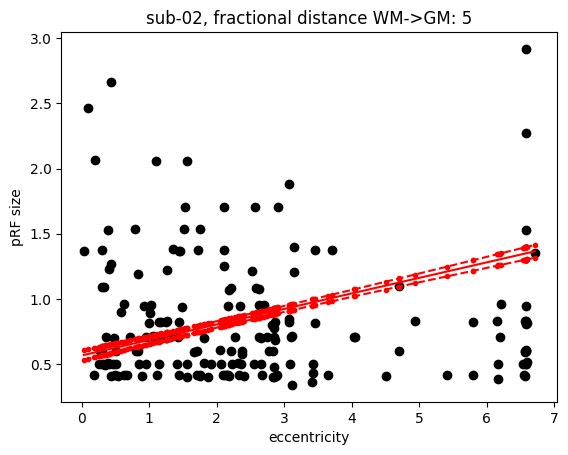

Intercept: 0.5648244407910157
t = 29.35, p = 0.00000
Slope: 0.11907750658685913
t = 21.39, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


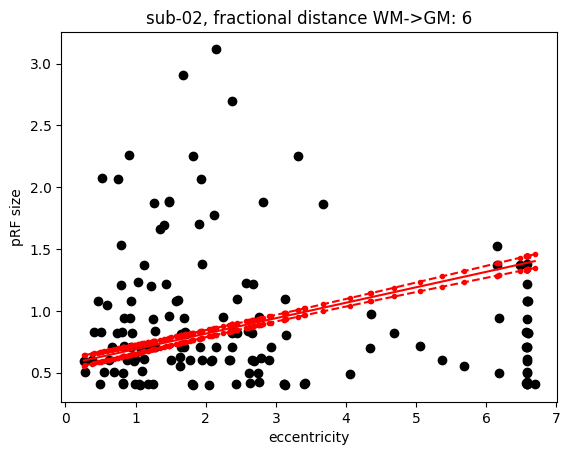

Intercept: 0.5647789647132657
t = 24.71, p = 0.00000
Slope: 0.12511974847738638
t = 19.31, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


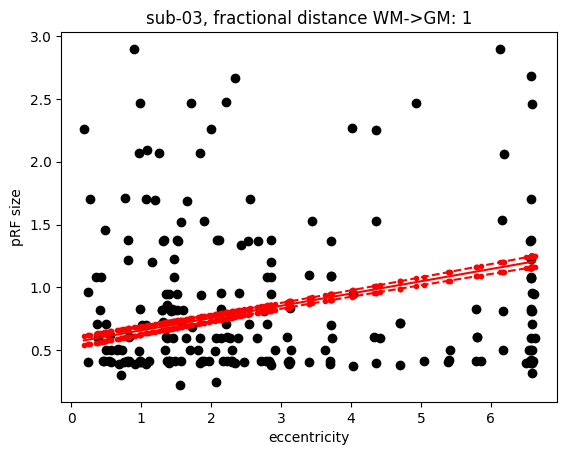

Intercept: 0.5601539763404111
t = 27.71, p = 0.00000
Slope: 0.0975925753134452
t = 17.99, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


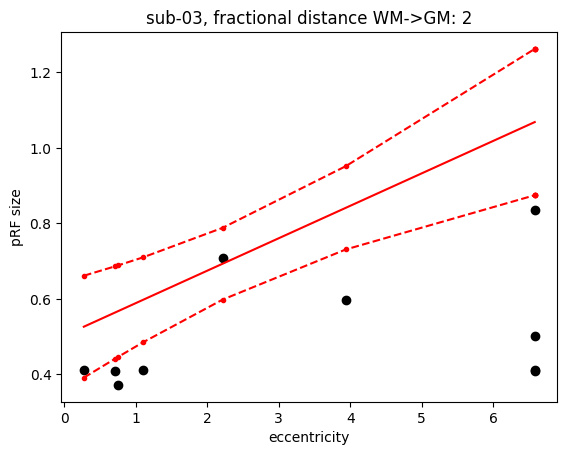

Intercept: 0.5029823654065807
t = 6.87, p = 0.00000
Slope: 0.08591700956854229
t = 3.99, p = 0.00007
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


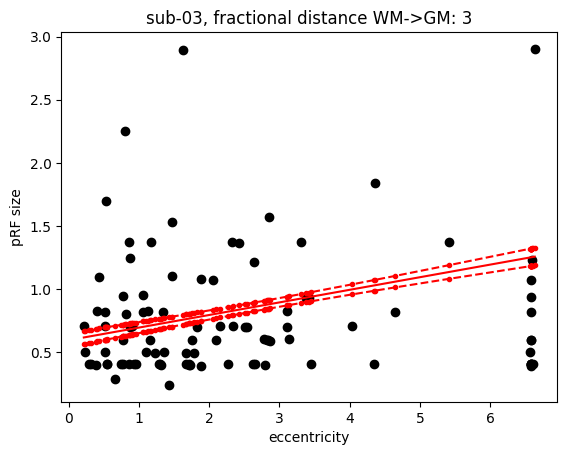

Intercept: 0.5973816852122054
t = 21.22, p = 0.00000
Slope: 0.09962561528202629
t = 12.42, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


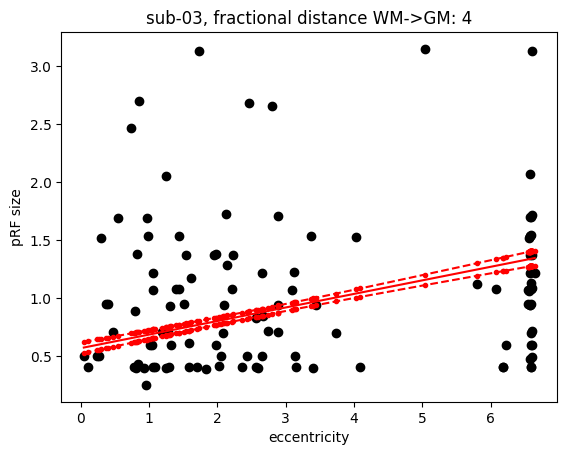

Intercept: 0.5701428690567972
t = 22.91, p = 0.00000
Slope: 0.11698157209514135
t = 15.93, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


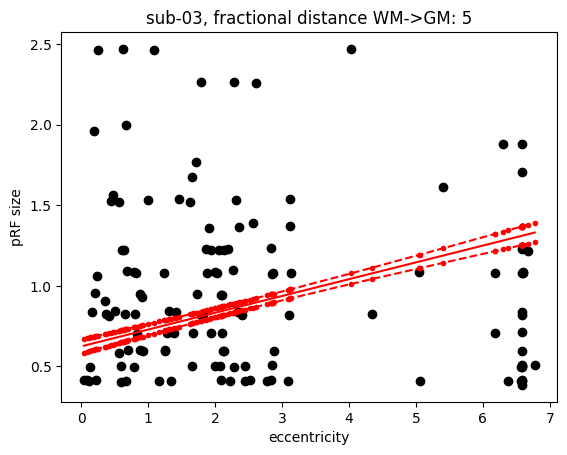

Intercept: 0.6242499310590448
t = 28.42, p = 0.00000
Slope: 0.10422293521055662
t = 15.91, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


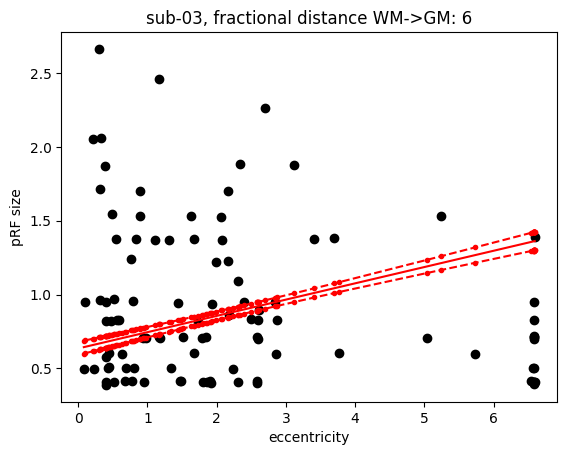

Intercept: 0.6351760074009869
t = 27.93, p = 0.00000
Slope: 0.11025939248561464
t = 15.90, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


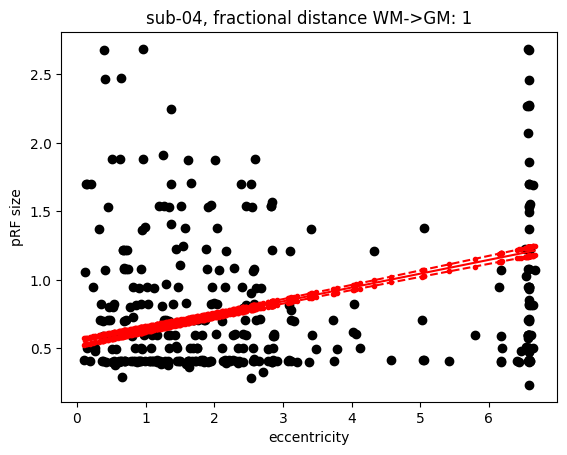

Intercept: 0.5407755504937366
t = 42.41, p = 0.00000
Slope: 0.10089917245345847
t = 27.14, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


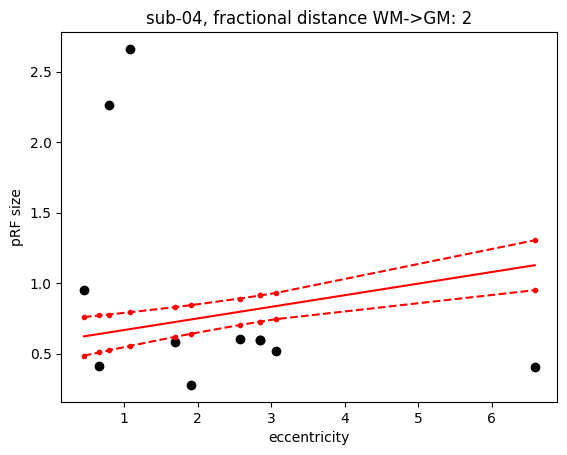

Intercept: 0.5846387504863227
t = 7.58, p = 0.00000
Slope: 0.08224625232735444
t = 3.93, p = 0.00009
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


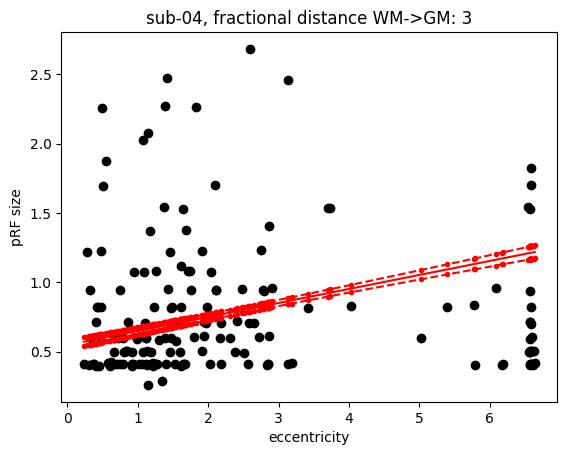

Intercept: 0.5472602960627941
t = 31.75, p = 0.00000
Slope: 0.10107512660318421
t = 19.49, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


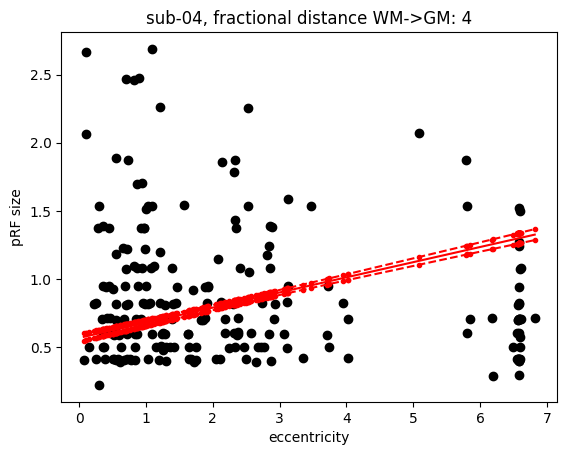

Intercept: 0.5674967013829939
t = 39.92, p = 0.00000
Slope: 0.11123857960436542
t = 25.98, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


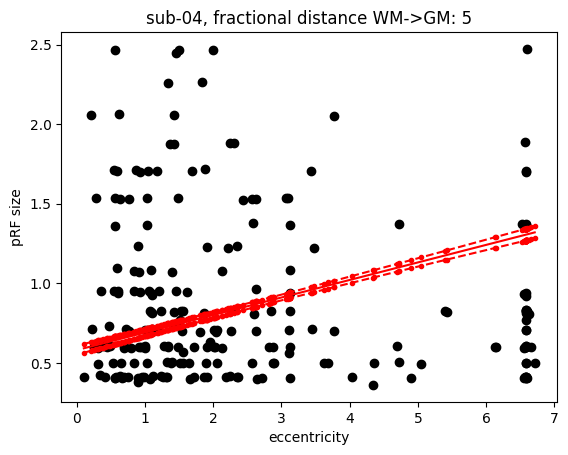

Intercept: 0.5801946944547756
t = 40.23, p = 0.00000
Slope: 0.1102302382961732
t = 26.15, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


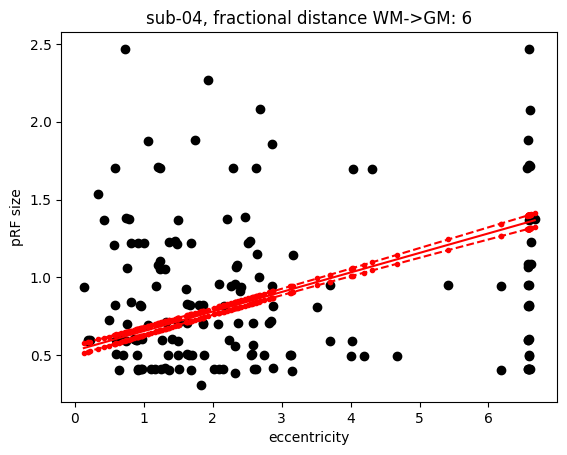

Intercept: 0.5296771793475128
t = 32.18, p = 0.00000
Slope: 0.12553723567138952
t = 25.28, p = 0.00000


In [22]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'lh') & 
                                     (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'rh') & 
                                            (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
#         # bin eccentricity data
#         bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
#         x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 20:
            idx=df_pRFxecc_stats_equivol.loc[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equivol.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope

    #     # print the quantiles
    #     print("95% quantiles:")
    #     print(quantiles.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

    #     # print the median
    #     print("Median:")
    #     print(median.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

        # save stats to df
        idx=df_pRFxecc_stats_equivol.loc[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_equivol.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        
    

In [23]:
df_pRFxecc_stats_equivol.head()


sub id  depth  intercept     slope         intercept-stats  \
0  sub-01    1.0   0.539262  0.072868  t = 55.76, p = 0.00000   
1  sub-01    2.0   0.502705  0.081828   t = 7.35, p = 0.00000   
2  sub-01    3.0   0.563522  0.063215  t = 41.41, p = 0.00000   
3  sub-01    4.0   0.564354  0.067861  t = 49.81, p = 0.00000   
4  sub-01    5.0   0.591469  0.065973  t = 55.65, p = 0.00000   

              slope-stats  pRF@2deg  
0  t = 23.31, p = 0.00000  0.684998  
1   t = 4.30, p = 0.00002  0.666360  
2  t = 13.60, p = 0.00000  0.689951  
3  t = 18.34, p = 0.00000  0.700077  
4  t = 18.53, p = 0.00000  0.723416

#### Plot estimated pRF size at target eccentricity

[ 0.0036931  -0.01190839  0.6875248 ]
R2 quadratic: 0.9464142485809951
R2 linear: 0.8232115872151267
[-0.00126809  0.02036861  0.7373306 ]
R2 quadratic: 0.8770071216392749
R2 linear: 0.8548028539497526
[0.00258396 0.00999485 0.71237549]
R2 quadratic: 0.6761831781170174
R2 linear: 0.6641868939793848
[-0.00161958  0.02236629  0.71503096]
R2 quadratic: 0.7285071052306206
R2 linear: 0.6964686505219768


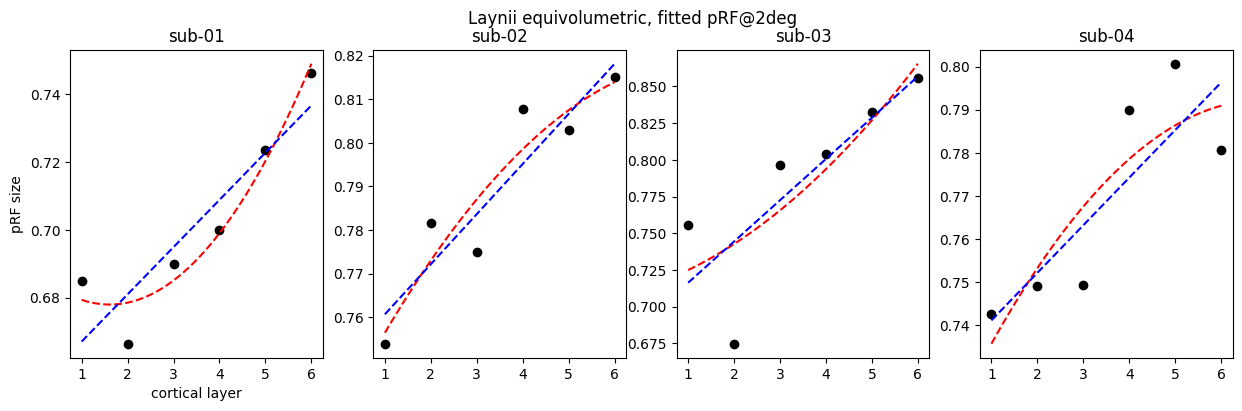

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))


for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.6, 1.0])
#     axs[sub_id].set_yticks(np.linspace(0.6,1.0,5)) 
#     axs[sub_id].set_ylim([0.65, 0.9])
#     axs[sub_id].set_yticks(np.linspace(0.65,0.9,6))  
    
plt.suptitle('Laynii equivolumetric, fitted pRF@2deg')
plt.show()
    
#     df_pRFxecc_stats_equivol.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

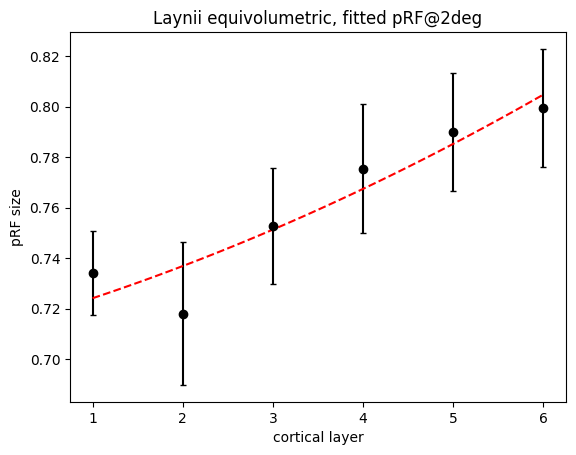

In [25]:
idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equivol.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equivol['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)

# data for plot
depth_plot    = df_pRFxecc_stats_equivol.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equivol.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Laynii equivolumetric, fitted pRF@2deg')
plt.show()

## Laynii layers: pRF per cortical layer fitted at manually-defined iso-eccentricity band

### Equidistant layering

#### pRF size at 2deg eccentricity (separately for each cortical layer)

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Set number of layers, eccentricities, subjects, hemispheres

In [26]:
n_layers   = 6
n_sub      = len(subject_list)
n_hem      = len(hem_list)

Thresholds

In [27]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

In [28]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [29]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist_2ecc = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [30]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        # lh
        idx=df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth_ecc2['hem'] == 'lh') & 
                                    (df_equidist_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth_ecc2['hem'] == 'rh') & 
                                    (df_equidist_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        # bin eccentricity data
        bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])
        
    

In [31]:
df_pRFxecc_stats_equidist_2ecc


sub id  depth  pRF@2deg
0   sub-01    1.0  0.706442
1   sub-01    2.0  0.688307
2   sub-01    3.0  0.699040
3   sub-01    4.0  0.709950
4   sub-01    5.0  0.705177
5   sub-01    6.0  0.748601
6   sub-02    1.0  0.880170
7   sub-02    2.0  0.715923
8   sub-02    3.0  0.834030
9   sub-02    4.0  0.849746
10  sub-02    5.0  0.804702
11  sub-02    6.0  0.850144
12  sub-03    1.0  0.874460
13  sub-03    2.0  0.950481
14  sub-03    3.0  0.958915
15  sub-03    4.0  0.902620
16  sub-03    5.0  0.971037
17  sub-03    6.0  0.949050
18  sub-04    1.0  0.817322
19  sub-04    2.0  0.722836
20  sub-04    3.0  0.810421
21  sub-04    4.0  0.881523
22  sub-04    5.0  0.892298
23  sub-04    6.0  0.886641

#### Plot estimated pRF size at target eccentricity

[ 0.00438872 -0.0229406   0.72331604]
R2 quadratic: 0.8406259211514432
R2 linear: 0.5007367014523403
[ 0.00706859 -0.04571096  0.87523388]
R2 quadratic: 0.12703589478364963
R2 linear: 0.014940210248438723
[-0.00446627  0.0420731   0.85490966]
R2 quadratic: 0.3973940083179811
R2 linear: 0.29129826711664086
[0.0024447  0.00934657 0.76538237]
R2 quadratic: 0.5772370812450422
R2 linear: 0.566912692919993


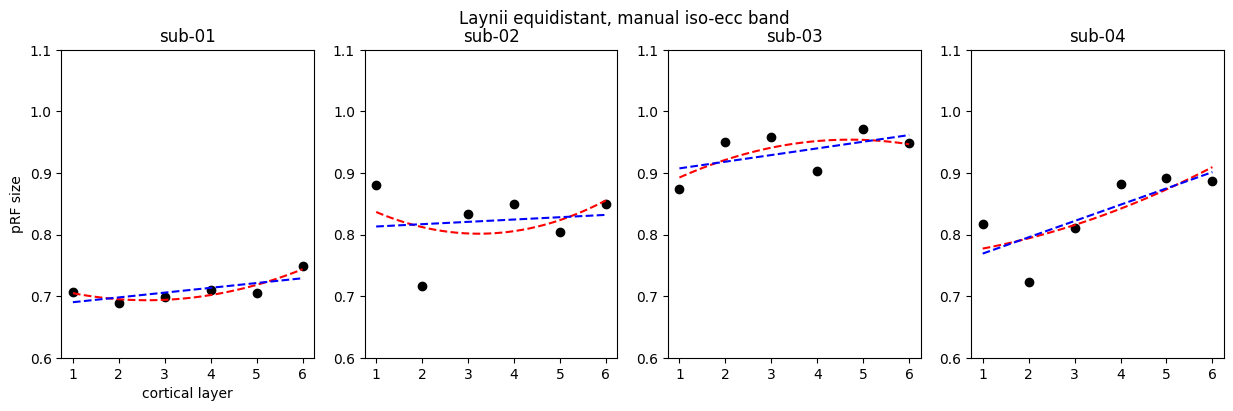

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.15])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6)) 
    axs[sub_id].set_ylim([0.6, 1.1])
    axs[sub_id].set_yticks(np.linspace(0.6,1.1,6)) 
    

plt.suptitle('Laynii equidistant, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equidist_2ecc.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

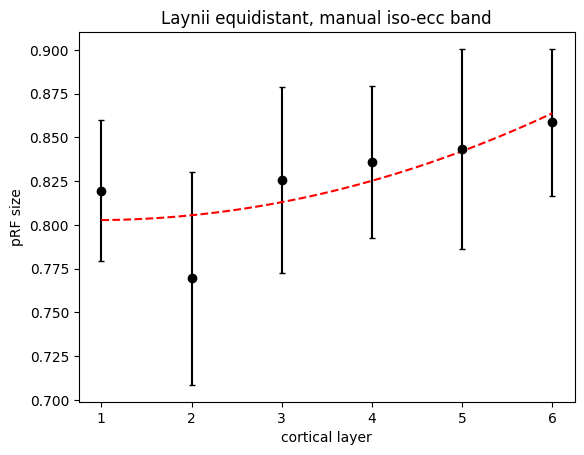

In [33]:
idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equidist_2ecc['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_equidist_2ecc.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equidist_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
#plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')


plt.title('Laynii equidistant, manual iso-ecc band')
plt.show()


### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Extract lh and rh sigma and ecc values at chosen rsq threshold

In [34]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

Create a dataframe to save intercept and slope stats

In [35]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol_2ecc = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [36]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        # lh
        idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                          (df_equivol_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                    (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                                 (df_equivol_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                    (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        # bin eccentricity data
        bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
        
    

In [37]:
df_pRFxecc_stats_equivol_2ecc.head()


sub id  depth  pRF@2deg
0  sub-01    1.0  0.706442
1  sub-01    2.0  0.685138
2  sub-01    3.0  0.698426
3  sub-01    4.0  0.706188
4  sub-01    5.0  0.707224

#### Plot estimated pRF size at target eccentricity

[ 0.0050079  -0.02645927  0.72585881]
R2 quadratic: 0.8807470715697404
R2 linear: 0.5108569443537061
[ 0.00848638 -0.05647604  0.89880818]
R2 quadratic: 0.32611996191446657
R2 linear: 0.017243191939612768
[8.30031823e-04 1.66453698e-02 8.50317459e-01]
R2 quadratic: 0.9360161655819182
R2 linear: 0.9332958549215359
[-0.00159854  0.03137653  0.75794112]
R2 quadratic: 0.5918354395434573
R2 linear: 0.5840226779691564


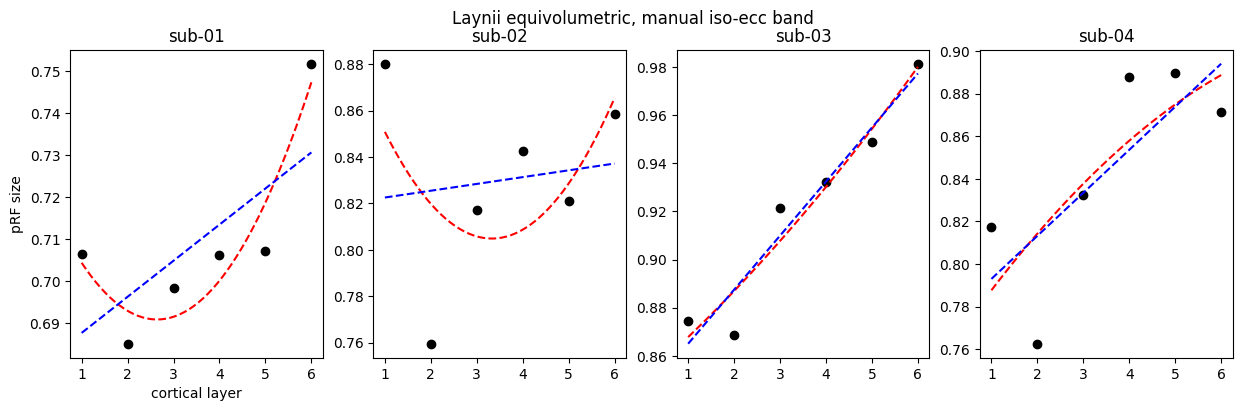

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))


for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.15])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6))  
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 
    
plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()
#     df_pRFxecc_stats_equivol_2ecc.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

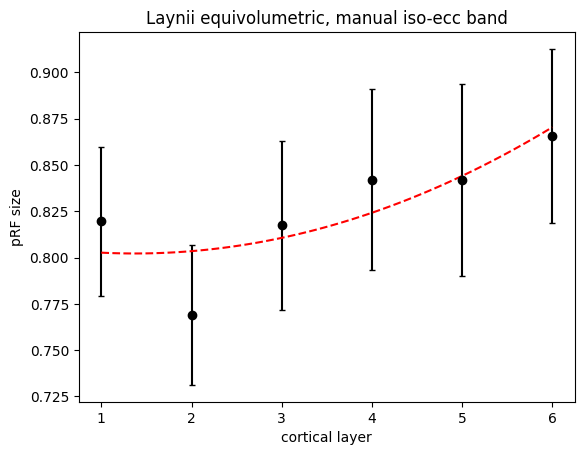

In [39]:
idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equivol_2ecc['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)

# ################################################
# # Fit the quadratic equation
# coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

# # Fit the linear equation
# coefs_linear = np.polyfit(depth, pRF_2deg, 1)

# # # Create a polynomial function from the coefficients
# # f_quadratic = np.poly1d(coefs_quadratic)
# # f_linear = np.poly1d(coefs_linear)

# # # calculate the R-squared
# # r_squared = r2_score(pRF_2deg, f_quadratic(depth))
# # print(f"R2 quadratic: {r_squared}")
# # r_squared = r2_score(pRF_2deg, f_linear(depth))
# # print(f"R2 linear: {r_squared}")
# #################################################

# data for plot
depth_plot    = df_pRFxecc_stats_equivol_2ecc.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equivol_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
#plt.plot(X_plot/n_layers,y_median,'b--')
# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')
plt.title('Laynii equivolumetric, manual iso-ecc band')
plt.show()


## #############################################################

## #############################################################

## Euclidean distances: pRF per cortical layer fitted at target eccentricity

### Equidistant layering

#### pRF size as a function of eccentricity (separately for each cortical layer)
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Set number of layers, eccentricities, subjects, hemispheres

In [40]:
n_layers = 10
n_sub      = len(subject_list)
n_hem      = len(hem_list)

Thresholds

In [41]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

Cortical distance bins

In [42]:
cd_bins  = np.linspace(-2.5,2.5,n_layers)
cd_bins

array([-2.5       , -1.94444444, -1.38888889, -0.83333333, -0.27777778,
        0.27777778,  0.83333333,  1.38888889,  1.94444444,  2.5       ])

Create a dataframe to save intercept and slope stats

In [43]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = cd_bins.tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_cortdist = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


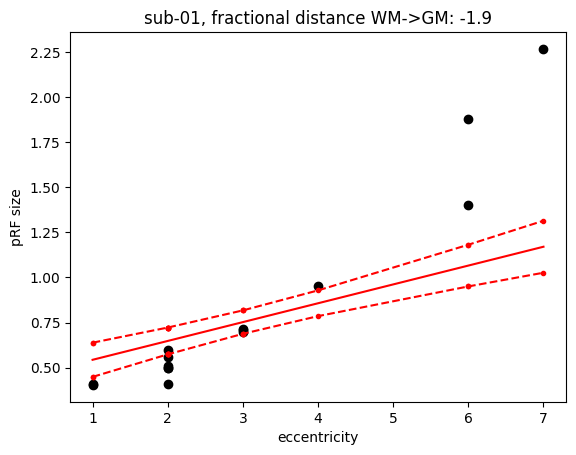

Intercept: 0.4388968418168208
t = 7.11, p = 0.00000
Slope: 0.10446783418514594
t = 6.21, p = 0.00000


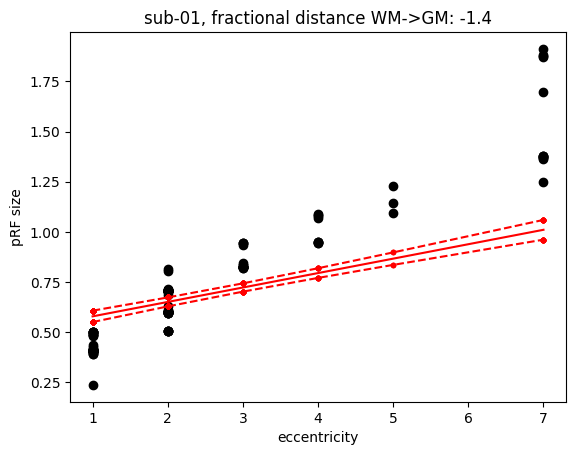

Intercept: 0.5065504517646697
t = 27.14, p = 0.00000
Slope: 0.0719611711970809
t = 13.15, p = 0.00000


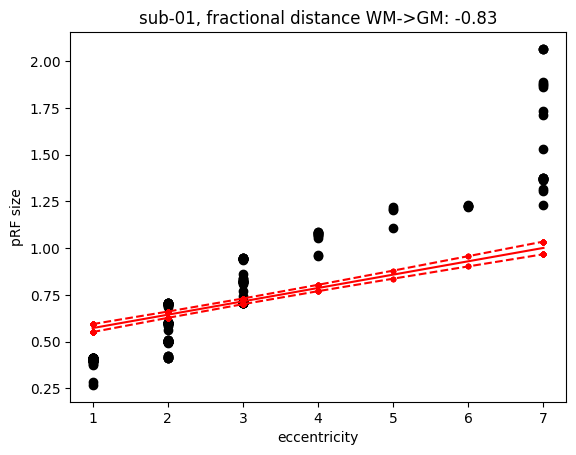

Intercept: 0.5003193913262902
t = 36.29, p = 0.00000
Slope: 0.07156665107090271
t = 18.64, p = 0.00000


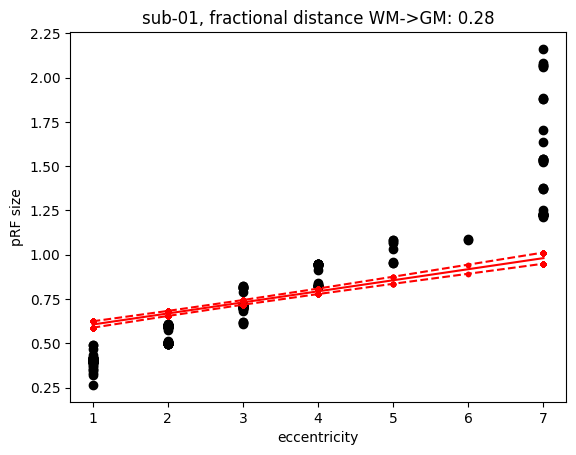

Intercept: 0.5432640179009987
t = 45.87, p = 0.00000
Slope: 0.0624928657396162
t = 17.93, p = 0.00000


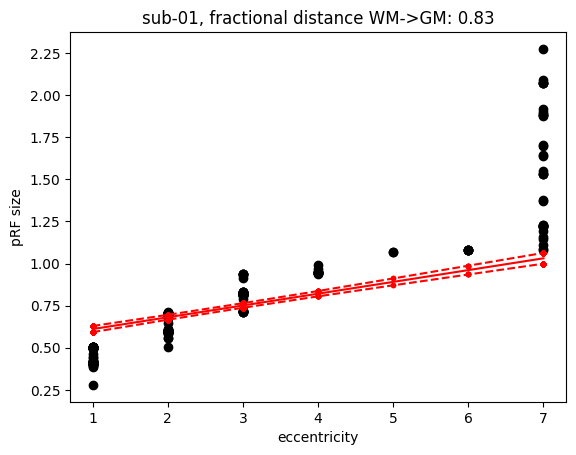

Intercept: 0.5410111943863853
t = 45.56, p = 0.00000
Slope: 0.07004982256854131
t = 20.05, p = 0.00000


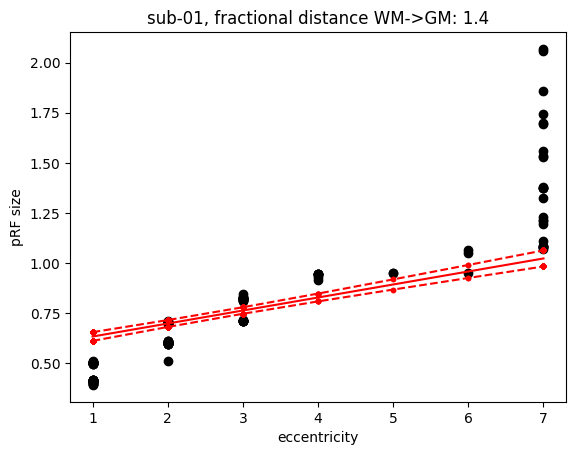

Intercept: 0.5666269485916231
t = 39.33, p = 0.00000
Slope: 0.06504226730987889
t = 14.88, p = 0.00000


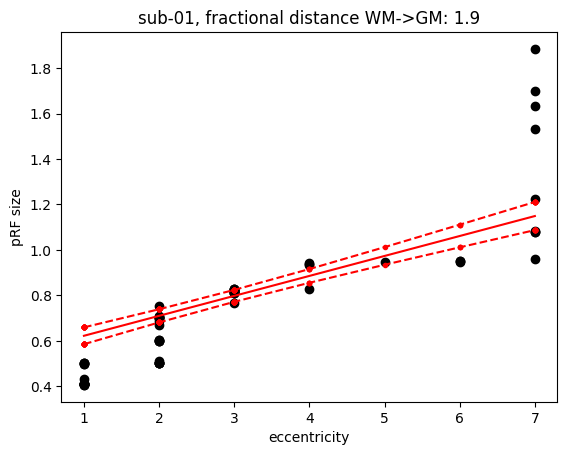

Intercept: 0.5349436303038781
t = 21.99, p = 0.00000
Slope: 0.08774909010309075
t = 12.56, p = 0.00000


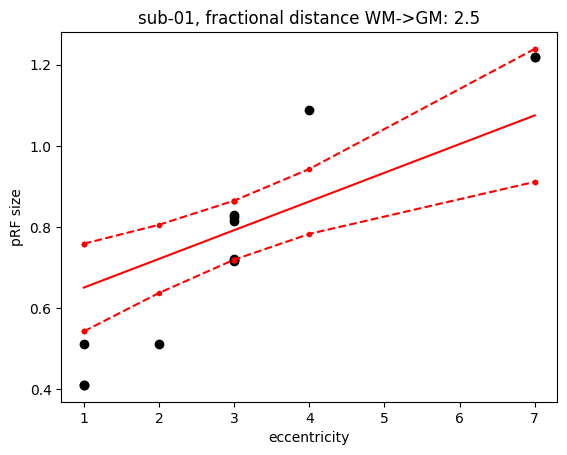

Intercept: 0.579676110219041
t = 8.20, p = 0.00000
Slope: 0.0707804153916877
t = 3.67, p = 0.00025
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


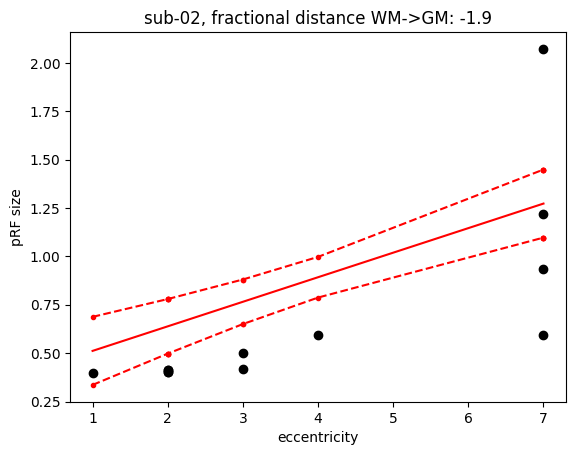

Intercept: 0.38475321513179883
t = 3.50, p = 0.00046
Slope: 0.12687872315326587
t = 5.29, p = 0.00000


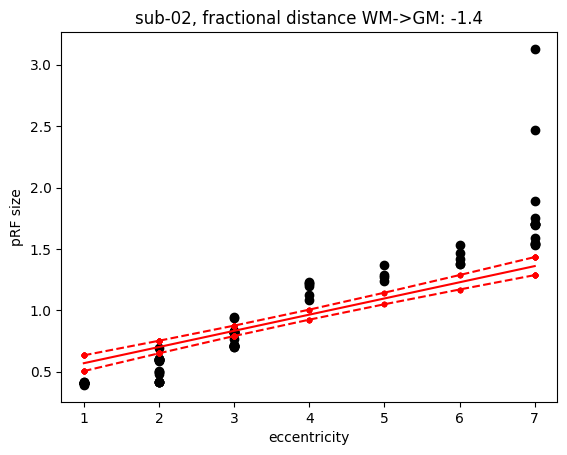

Intercept: 0.4364542629862148
t = 10.75, p = 0.00000
Slope: 0.13188337291736182
t = 13.92, p = 0.00000


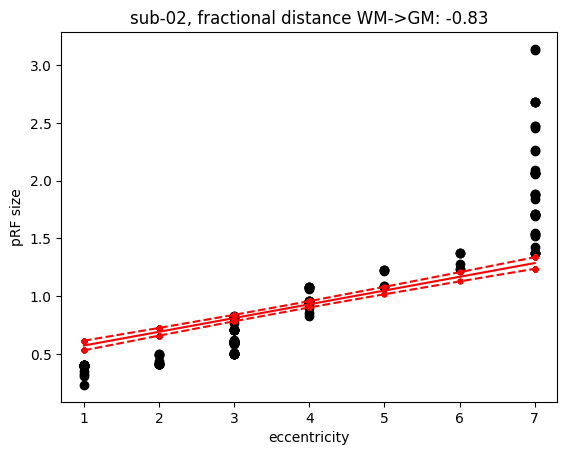

Intercept: 0.4523943401927534
t = 17.08, p = 0.00000
Slope: 0.11918628511429212
t = 18.92, p = 0.00000


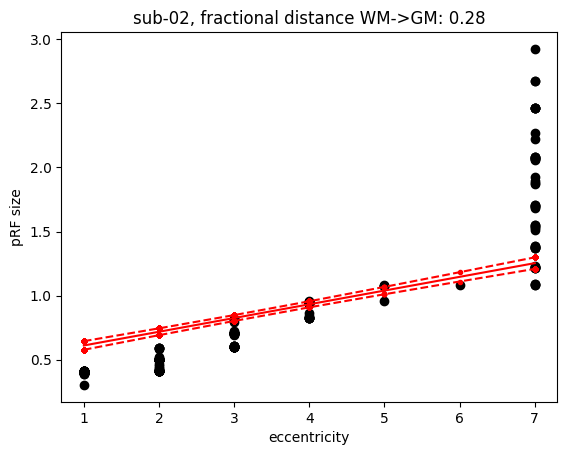

Intercept: 0.504344974566482
t = 23.44, p = 0.00000
Slope: 0.10706140046376733
t = 19.67, p = 0.00000


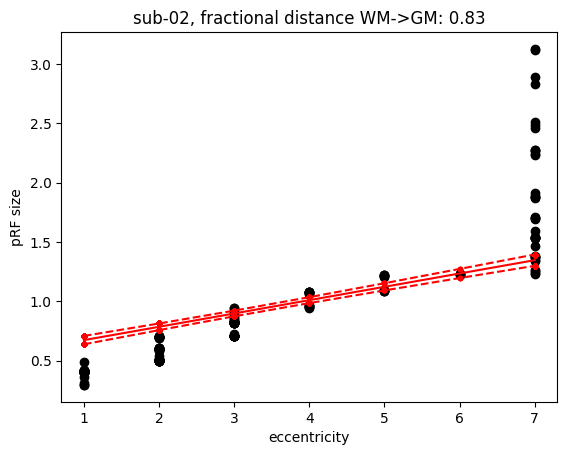

Intercept: 0.5597420208740467
t = 24.84, p = 0.00000
Slope: 0.11232156931708387
t = 19.60, p = 0.00000


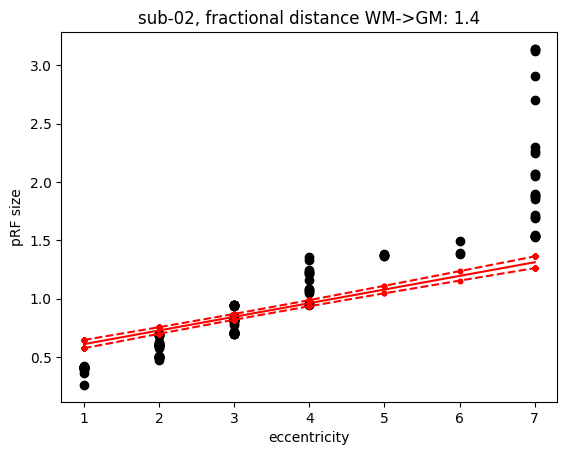

Intercept: 0.49281706174908096
t = 21.66, p = 0.00000
Slope: 0.1169802678801138
t = 19.77, p = 0.00000


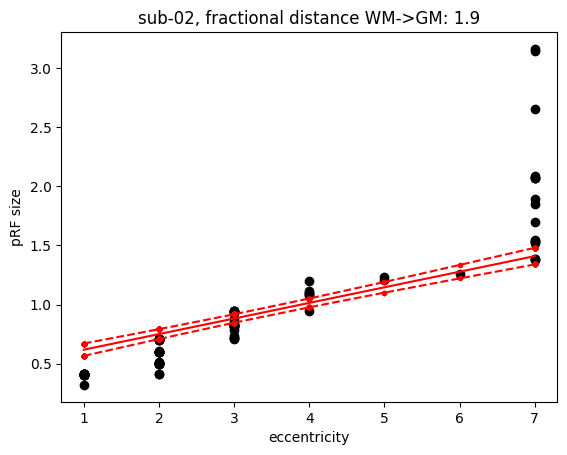

Intercept: 0.4858097326145836
t = 14.55, p = 0.00000
Slope: 0.1319296225807261
t = 15.57, p = 0.00000


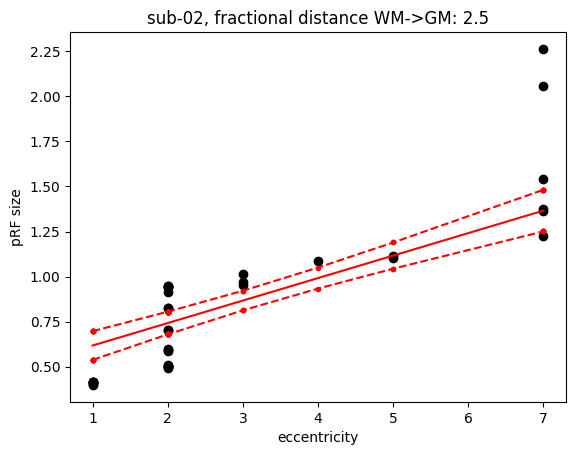

Intercept: 0.49259796969682323
t = 9.55, p = 0.00000
Slope: 0.12476447527261686
t = 9.14, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


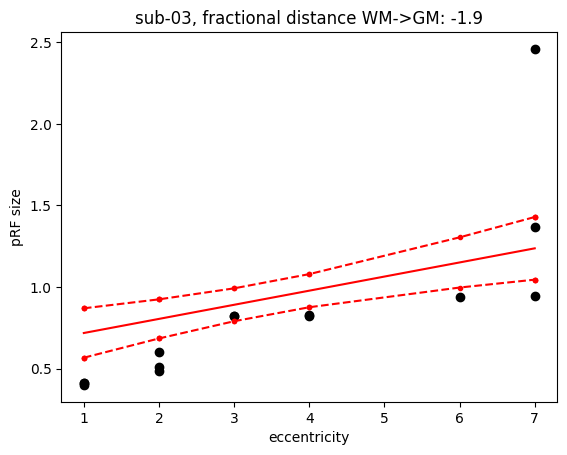

Intercept: 0.6318660488271641
t = 6.54, p = 0.00000
Slope: 0.08646619245601476
t = 3.63, p = 0.00028


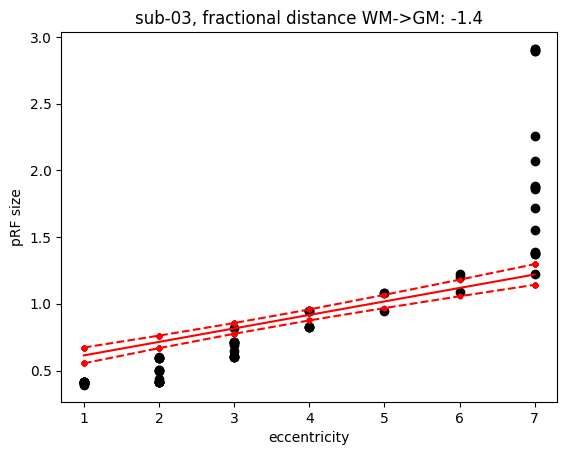

Intercept: 0.5121215009995106
t = 13.60, p = 0.00000
Slope: 0.10104570296086865
t = 10.76, p = 0.00000


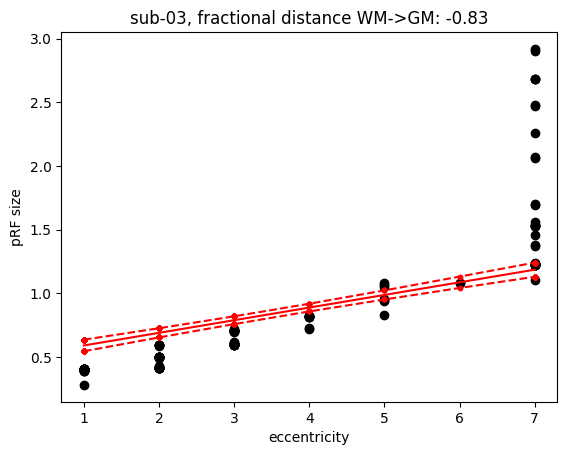

Intercept: 0.49250992319153375
t = 17.12, p = 0.00000
Slope: 0.0991568052722481
t = 14.32, p = 0.00000


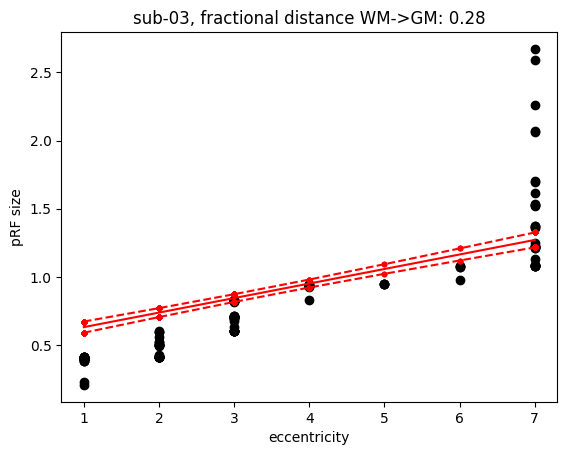

Intercept: 0.5239069430345293
t = 20.07, p = 0.00000
Slope: 0.106675271560805
t = 16.28, p = 0.00000


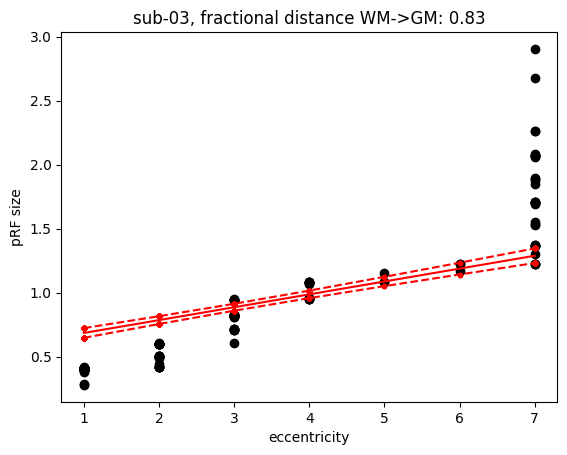

Intercept: 0.5840142726692088
t = 23.82, p = 0.00000
Slope: 0.1005711188418022
t = 15.34, p = 0.00000


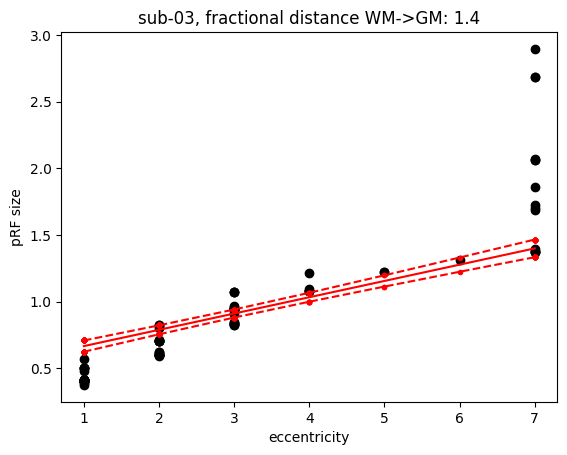

Intercept: 0.5442010343141013
t = 19.92, p = 0.00000
Slope: 0.12220566424379828
t = 16.26, p = 0.00000


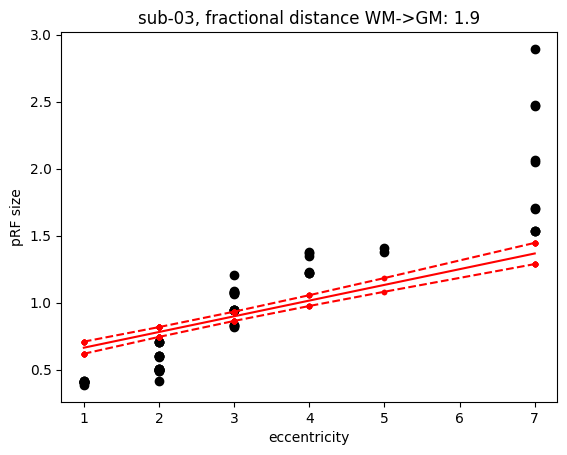

Intercept: 0.5467827549072626
t = 18.63, p = 0.00000
Slope: 0.11720067130335439
t = 13.69, p = 0.00000


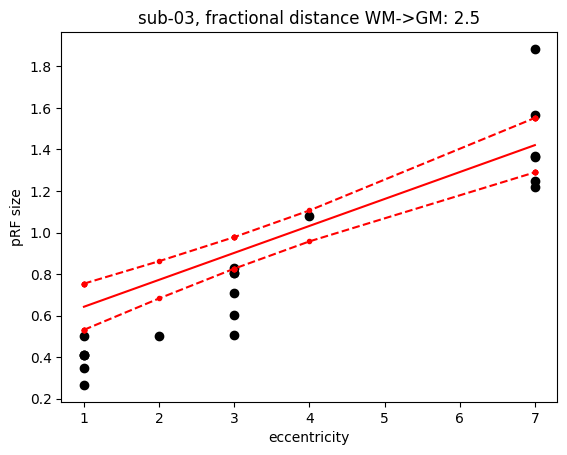

Intercept: 0.5130902159140684
t = 7.35, p = 0.00000
Slope: 0.1296561064078529
t = 7.94, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


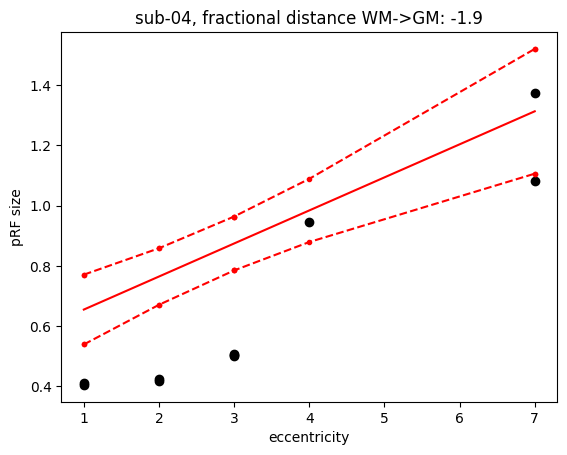

Intercept: 0.544720872225734
t = 7.21, p = 0.00000
Slope: 0.10984956385781003
t = 4.93, p = 0.00000


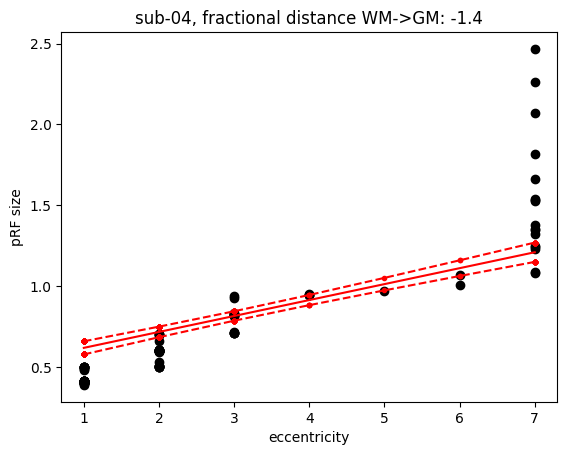

Intercept: 0.5185427795457744
t = 19.99, p = 0.00000
Slope: 0.09864683229311882
t = 14.42, p = 0.00000


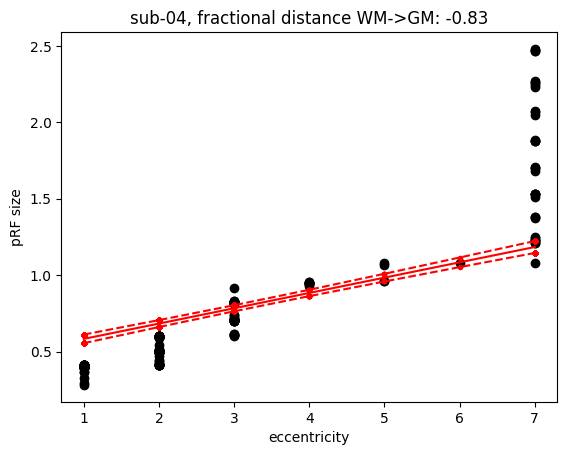

Intercept: 0.4832191951902205
t = 26.98, p = 0.00000
Slope: 0.10013752212256855
t = 21.97, p = 0.00000


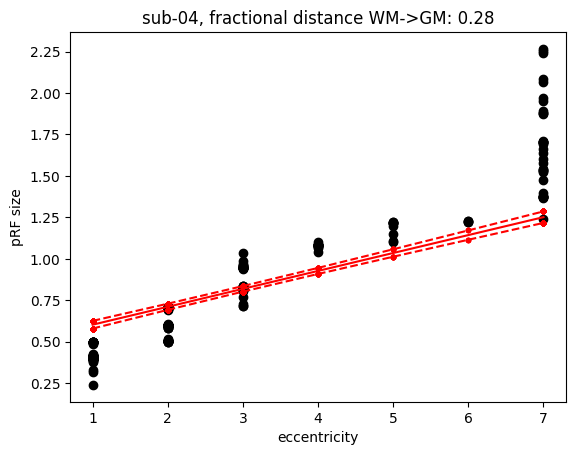

Intercept: 0.49463415185905524
t = 33.58, p = 0.00000
Slope: 0.10810650562210763
t = 27.53, p = 0.00000


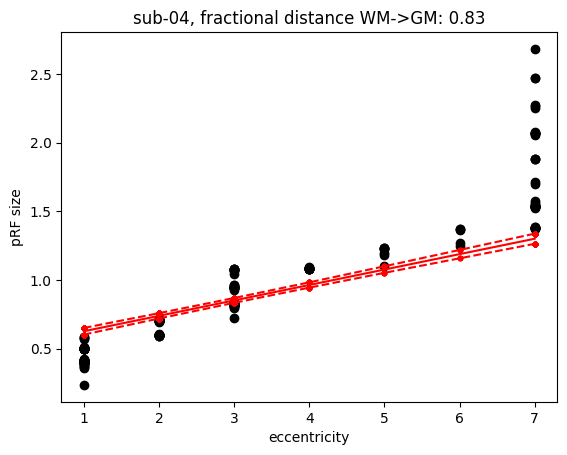

Intercept: 0.5144357537930331
t = 33.25, p = 0.00000
Slope: 0.11224279880605945
t = 26.85, p = 0.00000


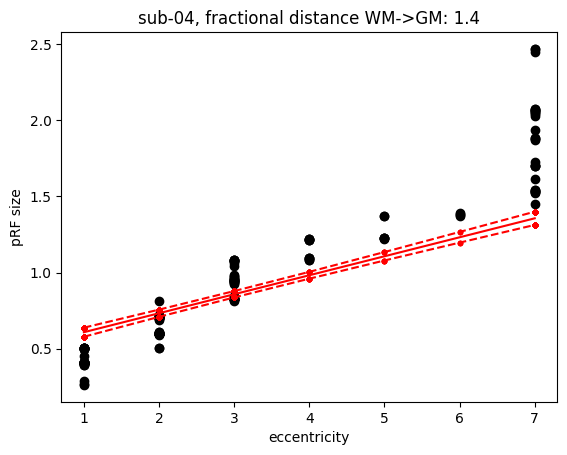

Intercept: 0.48238973485708053
t = 25.13, p = 0.00000
Slope: 0.12486421730860606
t = 24.61, p = 0.00000


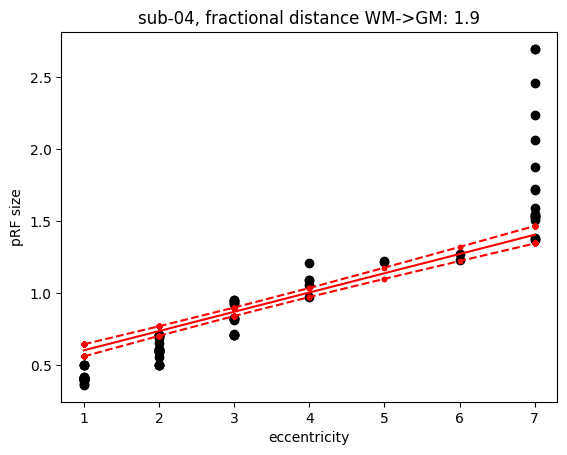

Intercept: 0.4680230683779061
t = 17.38, p = 0.00000
Slope: 0.13379265876999158
t = 18.89, p = 0.00000


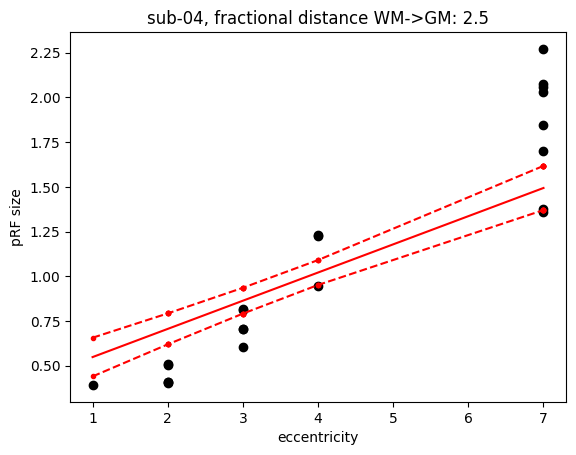

Intercept: 0.3905240744566698
t = 5.73, p = 0.00000
Slope: 0.15758948563347827
t = 9.97, p = 0.00000


In [44]:
for sub_id in range(0,len(subject_list)):
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(subject_list[sub_id])
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    # lh
    idx=df_pRF_per_cortdist.loc[(df_pRF_per_cortdist['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist['roi'] == 'V1') & 
                                (df_pRF_per_cortdist['hem'] == 'lh')].index.tolist()
    lh_sigma = np.stack(df_pRF_per_cortdist.loc[idx, 'pRF size'].to_numpy(), axis=0)
    lh_ecc   = np.stack(df_pRF_per_cortdist.loc[idx, 'ecc'].to_numpy(), axis=0)
    lh_rsq   = np.stack(df_pRF_per_cortdist.loc[idx, 'rsq'].to_numpy(), axis=0)
    lh_cortdist = np.stack(df_pRF_per_cortdist.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # rh
    idx=df_pRF_per_cortdist.loc[(df_pRF_per_cortdist['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist['roi'] == 'V1') & 
                                (df_pRF_per_cortdist['hem'] == 'rh')].index.tolist()
    rh_sigma = np.stack(df_pRF_per_cortdist.loc[idx, 'pRF size'].to_numpy(), axis=0)
    rh_ecc   = np.stack(df_pRF_per_cortdist.loc[idx, 'ecc'].to_numpy(), axis=0)
    rh_rsq   = np.stack(df_pRF_per_cortdist.loc[idx, 'rsq'].to_numpy(), axis=0)
    rh_cortdist = np.stack(df_pRF_per_cortdist.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # concatenate lh&rh
    y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
    x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
    r2       = np.concatenate((lh_rsq.T,rh_rsq.T))
    cortdist = np.concatenate((lh_cortdist.T,rh_cortdist.T))
    
    # threshold by r2
    y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
    x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
    cortdist    = np.atleast_2d(cortdist[r2>rsq_thresh]).T
    
    # threshold by sigma (only positive)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
    cortdist = np.atleast_2d(cortdist[y_sigma>0]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

    # threshold by sigma (below threshold)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
    cortdist = np.atleast_2d(cortdist[y_sigma<pRF_thresh]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T

    # also remove outliers
    y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
    y_sigma            = y_sigma[idx_or,:]
    x_ecc              = x_ecc[idx_or,:]
    cortdist           = cortdist[idx_or,:]

    # bin eccentricity data
    bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    x_ecc=np.digitize(x_ecc,bins=bins)

    # bin cortical distances
    cortdist=np.digitize(cortdist,cd_bins)
    cortdist_=np.zeros(len(cortdist))
    for n in range(0,len(cortdist)):
        cortdist_[n] = cd_bins[(cortdist[n]-1)]
    cortdist=np.expand_dims(cortdist_, axis=1)
    
    # save full array of sigma, ecc
    y_sigma_all=y_sigma
    x_ecc_all=x_ecc
    
    # loop through binned cortical distances
    for depth_idx in depth:
        y_sigma = y_sigma_all[cortdist==depth_idx]
        x_ecc   = x_ecc_all[cortdist==depth_idx]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_cortdist.loc[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_cortdist.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope


        # save stats to df
        idx=df_pRFxecc_stats_cortdist.loc[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_cortdist.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
        df_pRFxecc_stats_cortdist.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])

        df_pRFxecc_stats_cortdist.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
        df_pRFxecc_stats_cortdist.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])

        df_pRFxecc_stats_cortdist.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
        
    

In [45]:
df_pRFxecc_stats_cortdist.head()


sub id     depth  intercept     slope         intercept-stats  \
0  sub-01 -2.500000   1.068374  1.068374                1.068374   
1  sub-01 -1.944444   0.438897  0.104468   t = 7.11, p = 0.00000   
2  sub-01 -1.388889   0.506550  0.071961  t = 27.14, p = 0.00000   
3  sub-01 -0.833333   0.500319  0.071567  t = 36.29, p = 0.00000   
4  sub-01 -0.277778   0.526499  0.526499                0.526499   

              slope-stats  pRF@2deg  
0                1.068374       NaN  
1   t = 6.21, p = 0.00000  0.647833  
2  t = 13.15, p = 0.00000  0.650473  
3  t = 18.64, p = 0.00000  0.643453  
4                0.526499       NaN

#### Plot estimated pRF size at target eccentricity

[0.00345808 0.01613292 0.66356526]
R2 quadratic: 0.9776369260253283
R2 linear: 0.9280957035067323
[-0.00888259  0.0258124   0.73114992]
R2 quadratic: 0.7715473560337823
R2 linear: 0.6198882847610937
[0.00751902 0.00522563 0.7395062 ]
R2 quadratic: 0.25455487998434145
R2 linear: 0.1270705174527028
[ 0.00359384 -0.0036989   0.71605656]
R2 quadratic: 0.09382340007619283
R2 linear: 0.015667024866456325


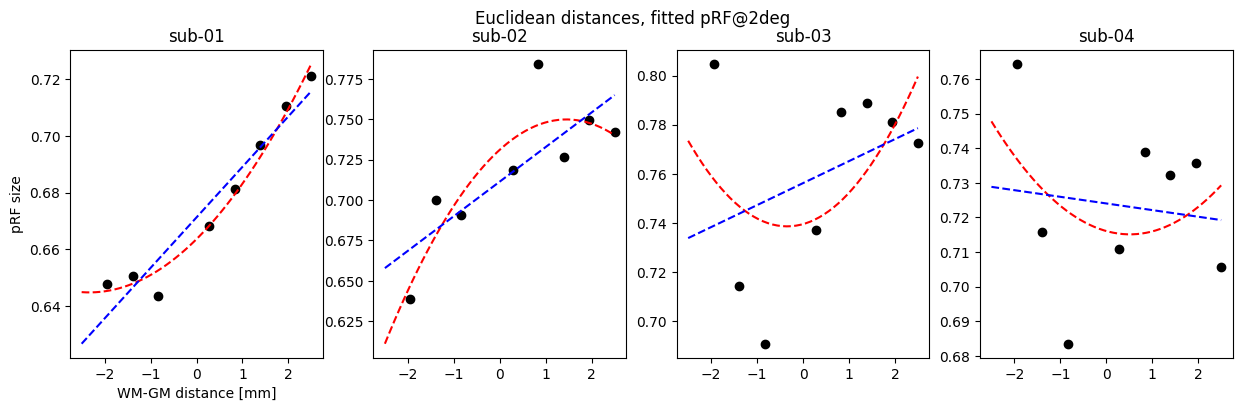

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_cortdist.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_cortdist.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(-2.5, 2.5, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('WM-GM distance [mm]')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.55, 0.95])
#     axs[sub_id].set_yticks(np.linspace(0.55,0.95,5)) 
#     axs[sub_id].set_ylim([0.6, 0.8])
#     axs[sub_id].set_yticks(np.linspace(0.6,0.8,3)) 

plt.suptitle('Euclidean distances, fitted pRF@2deg')
plt.show()
#     axs[sub_id].set_ylim([0.7, 1.1]4
#     axs[sub_id].set_yticks(np.linspace(0.7,1.1,5))    
    
#     df_pRFxecc_stats_cortdist.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

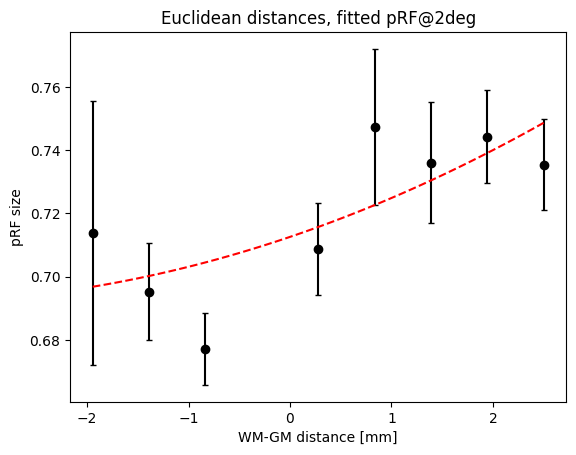

In [47]:
idx      = df_pRFxecc_stats_cortdist[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_cortdist.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_cortdist['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_cortdist.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_cortdist.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_cortdist.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('WM-GM distance [mm]')
plt.ylabel('pRF size')


plt.title('Euclidean distances, fitted pRF@2deg')
plt.show()


## Euclidean distances: pRF per cortical layer fitted at manually-defined iso-eccentricity band

#### pRF size at 2deg eccentricity (separately for each cortical depth bin)

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Set number of layers, eccentricities, subjects, hemispheres

In [48]:
n_layers = 10
n_sub      = len(subject_list)
n_hem      = len(hem_list)

Thresholds

In [49]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

Cortical distance bins

In [50]:
cd_bins  = np.linspace(-2.5,2.5,n_layers)
cd_bins

array([-2.5       , -1.94444444, -1.38888889, -0.83333333, -0.27777778,
        0.27777778,  0.83333333,  1.38888889,  1.94444444,  2.5       ])

Create a dataframe to save intercept and slope stats

In [51]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = cd_bins.tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_cortdist_2ecc = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [52]:
for sub_id in range(0,len(subject_list)):
    # lh
    idx=df_pRF_per_cortdist_ecc2.loc[(df_pRF_per_cortdist_ecc2['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist_ecc2['hem'] == 'lh') & 
                                (df_pRF_per_cortdist_ecc2['roi'] == 'V1')].index.tolist()
    lh_sigma = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
    lh_ecc   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
    lh_rsq   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
    lh_cortdist = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # rh
    idx=df_pRF_per_cortdist_ecc2.loc[(df_pRF_per_cortdist_ecc2['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist_ecc2['hem'] == 'rh') & 
                                (df_pRF_per_cortdist_ecc2['roi'] == 'V1')].index.tolist()
    rh_sigma = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
    rh_ecc   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
    rh_rsq   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
    rh_cortdist = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # concatenate lh&rh
    y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
    x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
    r2       = np.concatenate((lh_rsq.T,rh_rsq.T))
    cortdist = np.concatenate((lh_cortdist.T,rh_cortdist.T))
    
    # threshold by r2
    y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
    x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
    cortdist    = np.atleast_2d(cortdist[r2>rsq_thresh]).T
    
    # threshold by sigma (only positive)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
    cortdist = np.atleast_2d(cortdist[y_sigma>0]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

    # threshold by sigma (below threshold)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
    cortdist = np.atleast_2d(cortdist[y_sigma<pRF_thresh]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T

    # also remove outliers
    y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
    y_sigma            = y_sigma[idx_or,:]
    x_ecc              = x_ecc[idx_or,:]
    cortdist           = cortdist[idx_or,:]

    # bin eccentricity data
    bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    x_ecc=np.digitize(x_ecc,bins=bins)

    # bin cortical distances
    cortdist=np.digitize(cortdist,cd_bins)
    cortdist_=np.zeros(len(cortdist))
    for n in range(0,len(cortdist)):
        cortdist_[n] = cd_bins[(cortdist[n]-1)]
    cortdist=np.expand_dims(cortdist_, axis=1)
    
    # save full array of sigma, ecc
    y_sigma_all=y_sigma
    x_ecc_all=x_ecc
    
    # loop through binned cortical distances
    for depth_idx in depth:
        y_sigma = y_sigma_all[cortdist==depth_idx]
        x_ecc   = x_ecc_all[cortdist==depth_idx]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_cortdist_2ecc.loc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist_2ecc['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_cortdist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_cortdist_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_cortdist_2ecc.loc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist_2ecc['depth'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_cortdist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_cortdist_2ecc.index[idx])
        
    

In [53]:
df_pRFxecc_stats_cortdist_2ecc


sub id     depth  pRF@2deg
0   sub-01 -2.500000       NaN
1   sub-01 -1.944444  0.748779
2   sub-01 -1.388889  0.704224
3   sub-01 -0.833333  0.693622
4   sub-01 -0.277778       NaN
5   sub-01  0.277778  0.700198
6   sub-01  0.833333  0.716131
7   sub-01  1.388889  0.712063
8   sub-01  1.944444  0.762575
9   sub-01  2.500000  0.783585
10  sub-02 -2.500000       NaN
11  sub-02 -1.944444  0.798284
12  sub-02 -1.388889  0.884176
13  sub-02 -0.833333  0.855623
14  sub-02 -0.277778       NaN
15  sub-02  0.277778  0.828955
16  sub-02  0.833333  0.890586
17  sub-02  1.388889  0.784130
18  sub-02  1.944444  0.833373
19  sub-02  2.500000  0.862262
20  sub-03 -2.500000       NaN
21  sub-03 -1.944444  0.886648
22  sub-03 -1.388889  0.886240
23  sub-03 -0.833333  0.866632
24  sub-03 -0.277778       NaN
25  sub-03  0.277778  0.927140
26  sub-03  0.833333  0.943821
27  sub-03  1.388889  0.941876
28  sub-03  1.944444  0.955906
29  sub-03  2.500000  0.993201
30  sub-04 -2.500000       NaN
31  sub-04 -1.944444  0.778619
32  sub-04 -1.388889  0.820152
33  sub-04 -0.833333  0.817736
34  sub-04 -0.277778       NaN
35  sub-04  0.277778  0.847215
36  sub-04  0.833333  0.894846
37  sub-04  1.388889  0.889811
38  sub-04  1.944444  0.882098
39  sub-04  2.500000  0.994536

#### Plot estimated pRF size at target eccentricity

[0.01390086 0.00349755 0.69318201]
R2 quadratic: 0.910927500007014
R2 linear: 0.2567689446408601
[-0.00252102  0.00152203  0.84767524]
R2 quadratic: 0.016165834530796896
R2 linear: 0.00013237165816148977
[0.00401504 0.02260206 0.90773111]
R2 quadratic: 0.9030183185261927
R2 linear: 0.8700455938567538
[0.00568954 0.03456864 0.84001449]
R2 quadratic: 0.8574359135614632
R2 linear: 0.8301065144301658


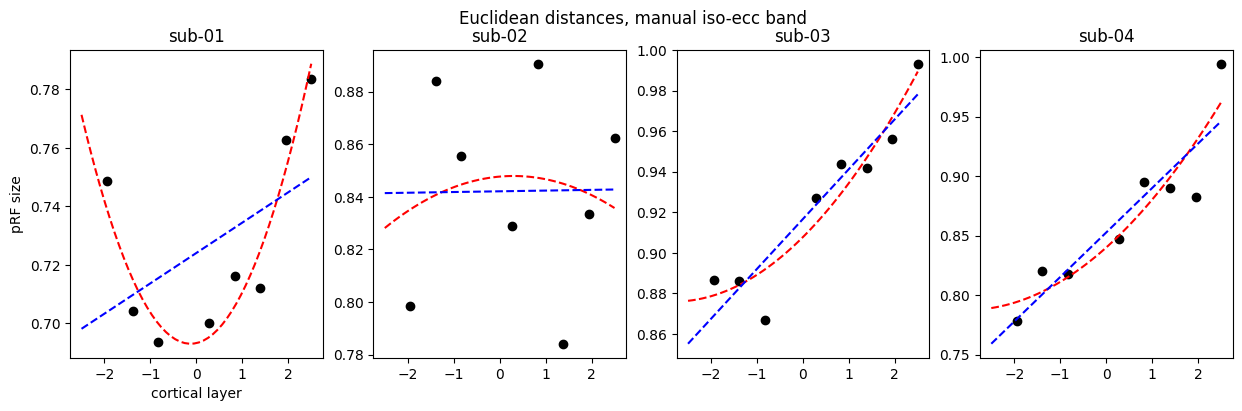

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist_2ecc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(-2.5, 2.5, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.6, 1.2])
#     axs[sub_id].set_yticks(np.linspace(0.6,1.2,7))   
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 

plt.suptitle('Euclidean distances, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_cortdist_2ecc.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

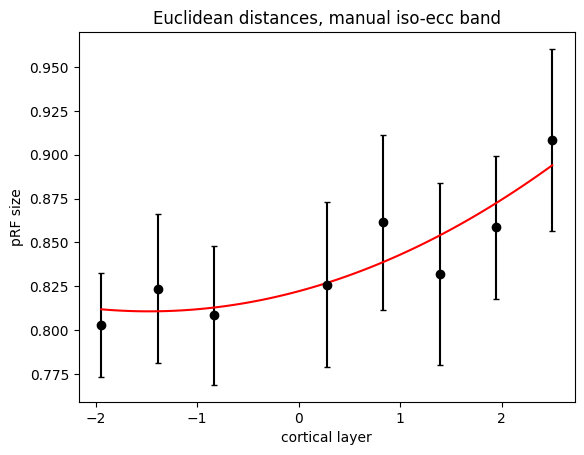

In [55]:
idx      = df_pRFxecc_stats_cortdist_2ecc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist_2ecc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_cortdist_2ecc['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_cortdist_2ecc.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_cortdist_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r-')
#plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Euclidean distances, manual iso-ecc band')
plt.show()


# ######################################################

# ######################################################

# Pooling data from all participants

Set number of layers, eccentricities, subjects, hemispheres

In [91]:
n_layers   = 6
n_sub      = len(subject_list)
n_hem      = len(hem_list)


Thresholds

In [92]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

In [95]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth  = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRF_filtered_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRFs': pRF_2deg
})

In [132]:
for depth_idx in depth:
    for sub_id in range(0,len(subject_list)):
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'lh') & 
                                     (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'rh') & 
                                            (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        print('Nr voxels at layer '+str(depth_idx)+': '+str(len(y_sigma)))
        
        
         # save stats to df
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRF_filtered_equivol['depth'] == depth_idx)].index.tolist()

        df_pRF_filtered_equivol.loc[idx, 'pRFs'] = pd.Series([y_sigma], index=df_pRF_filtered_equivol.index[idx])

        

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 3679
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 2754
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 2157
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 3365
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 101
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%

In [161]:
df_pRF_filtered_equivol.head()

sub id  depth                                               pRFs
0  sub-01    1.0  [[1.530799371375438], [0.49762651903208505], [...
1  sub-01    2.0  [[0.39990071754897566], [0.5922531331289524], ...
2  sub-01    3.0  [[0.41297039532836194], [0.39505644227768305],...
3  sub-01    4.0  [[0.9463248873475711], [0.8219629342293395], [...
4  sub-01    5.0  [[0.5926230033243476], [0.5942778238262738], [...

In [158]:
all_sigma_list = []
all_pos_list = []

for depth_idx in depth:
    sigmas_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx)].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
    all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    all_pos_list.append(depth_idx)

In [186]:
pRFsizes = all_sigma_list

Text(0.5, 0, 'Depths (relative index)')

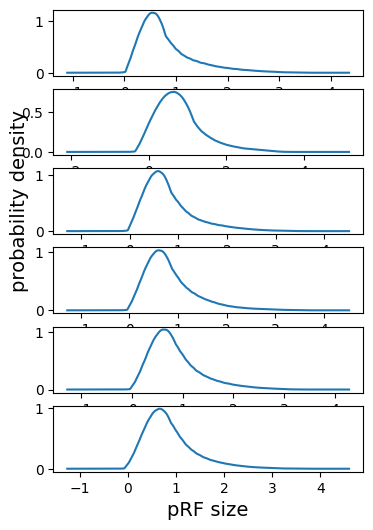

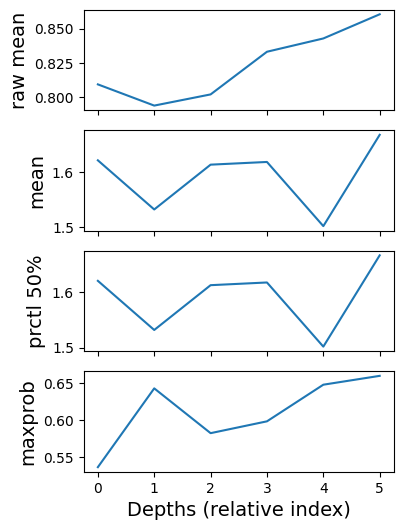

In [187]:
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

In [185]:
len(all_sigma_list[5])

5437

# ALL ROIS

## Laynii layers: pRF per cortical layer fitted at manually-defined iso-eccentricity band

### Equidistant layering

#### pRF size at 2deg eccentricity (separately for each cortical layer)

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Set number of layers, eccentricities, subjects, hemispheres

In [56]:
n_layers   = 6
n_rois     = 3
n_sub      = len(subject_list)
n_hem      = len(hem_list)

Thresholds

In [57]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

In [58]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [59]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist_2ecc = pd.DataFrame({
    'sub id' : subs,
    'roi' : rois,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [60]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        for roi_id in range(0,len(roi_list)):
            # lh
            idx=df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equidist_per_depth_ecc2['hem'] == 'lh') & 
                                        (df_equidist_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # rh
            idx      = df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equidist_per_depth_ecc2['hem'] == 'rh') & 
                                        (df_equidist_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

    #         y_sigma = lh_sigma
    #         x_ecc = lh_ecc
    #         r2 = lh_rsq

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]

            # bin eccentricity data
            bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            x_ecc=np.digitize(x_ecc,bins=bins)

        #     # random shuffle
        #     shuffle_indices = np.random.permutation(len(y_sigma))
        #     y_sigma = y_sigma[shuffle_indices]
        #     x_ecc = x_ecc[shuffle_indices]

            if len(y_sigma) < 30:
                idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
                df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])
                continue


            # get pRF estimate at 2deg
            pRF_est = np.mean(y_sigma)


            # save stats to df
            idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()

            df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])

    

In [61]:
df_pRFxecc_stats_equidist_2ecc


sub id roi  depth  pRF@2deg
0   sub-01  V1    1.0  0.706442
1   sub-01  V1    2.0  0.688307
2   sub-01  V1    3.0  0.699040
3   sub-01  V1    4.0  0.709950
4   sub-01  V1    5.0  0.705177
..     ...  ..    ...       ...
67  sub-04  V3    2.0       NaN
68  sub-04  V3    3.0  0.987475
69  sub-04  V3    4.0  0.913186
70  sub-04  V3    5.0  0.918642
71  sub-04  V3    6.0  0.932921

[72 rows x 4 columns]

#### Plot estimated pRF size at target eccentricity

[ 0.00438872 -0.0229406   0.72331604]
R2 quadratic: 0.8406259211514432
R2 linear: 0.5007367014523403
[-7.07692172e-04  9.23455642e-03  7.71320209e-01]
R2 quadratic: 0.2111253158173998
R2 linear: 0.19949357914077315
[-1.37209430e-04  2.84507251e-02  7.87253333e-01]
R2 quadratic: 0.3183576863035684
R2 linear: 0.3183407678278315
[ 0.00706859 -0.04571096  0.87523388]
R2 quadratic: 0.12703589478364963
R2 linear: 0.014940210248438723
[-0.00651868  0.05727709  0.85401549]
R2 quadratic: 0.1487248668082668
R2 linear: 0.08914519005682109
[ 0.00908582 -0.03454855  1.04501894]
R2 quadratic: 0.7670727725261466
R2 linear: 0.6110486581479
[-0.00446627  0.0420731   0.85490966]
R2 quadratic: 0.3973940083179811
R2 linear: 0.29129826711664086
[0.00333414 0.00281078 0.92830956]
R2 quadratic: 0.4001746997701141
R2 linear: 0.3867614495827081
[-0.00207887  0.05803847  0.75498283]
R2 quadratic: 0.8780490942718315
R2 linear: 0.8731388108265676
[0.0024447  0.00934657 0.76538237]
R2 quadratic: 0.5772370812450422

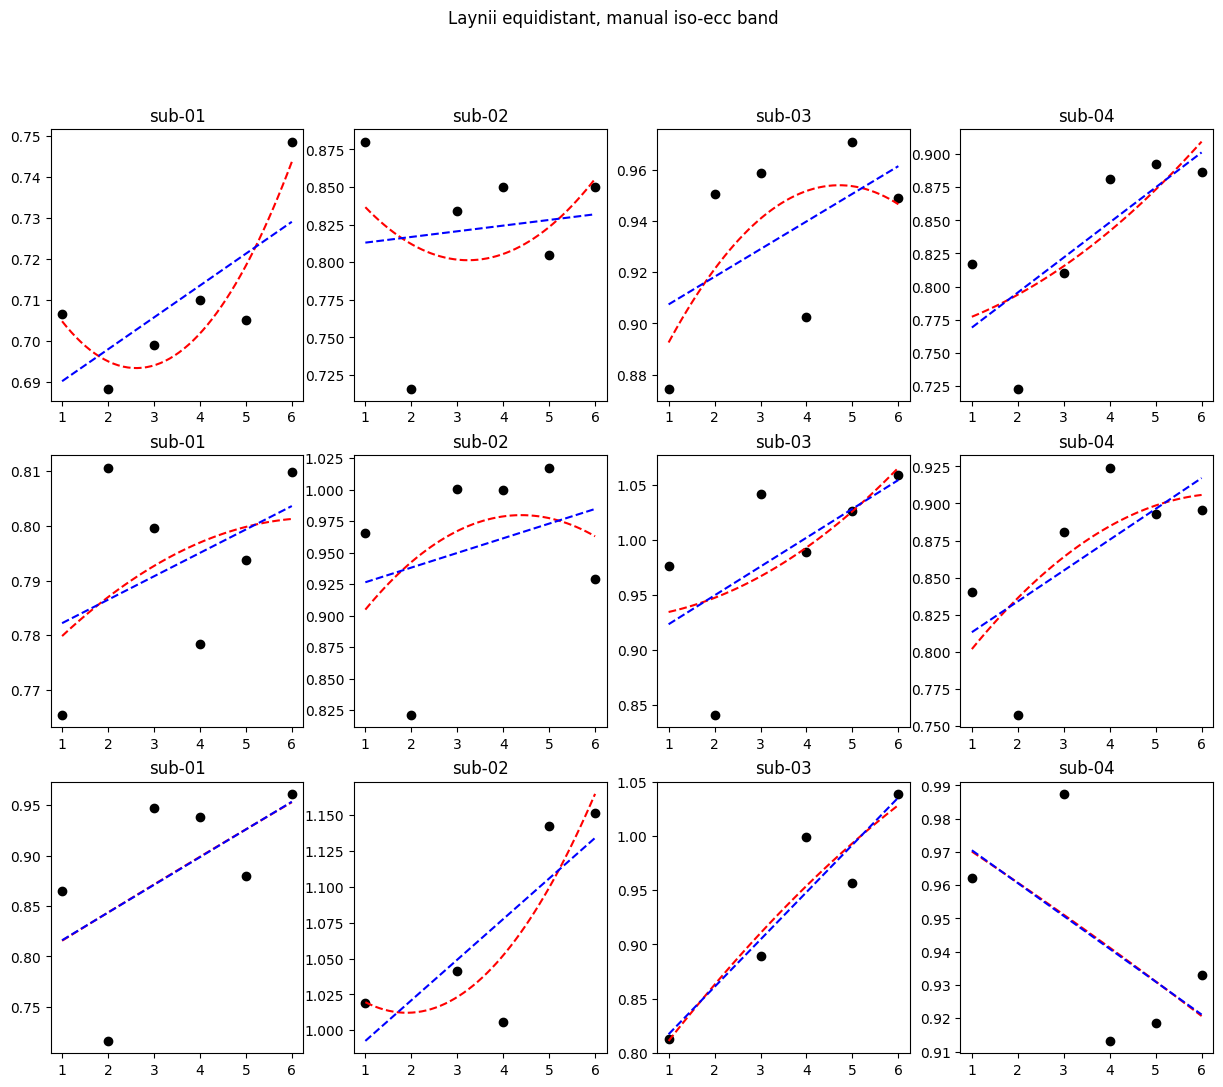

In [62]:
fig, axs = plt.subplots(nrows=len(roi_list), ncols=len(subject_list), figsize=(15, 12))

for sub_id in range(0,len(subject_list)):
    for roi_id in range(0,len(roi_list)):
        idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
        pRF_2deg = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values

        # omit nans
        idx = np.isfinite(pRF_2deg)
        pRF_2deg = pRF_2deg[idx]
        depth=depth[idx]

        # Fit the quadratic equation
        coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

        # Fit the linear equation
        coefs_linear = np.polyfit(depth, pRF_2deg, 1)

        # Print the coefficients
        print(coefs_quadratic)

        # Create a polynomial function from the coefficients
        f_quadratic = np.poly1d(coefs_quadratic)
        f_linear = np.poly1d(coefs_linear)

        # calculate the R-squared
        r_squared = r2_score(pRF_2deg, f_quadratic(depth))
        print(f"R2 quadratic: {r_squared}")
        r_squared = r2_score(pRF_2deg, f_linear(depth))
        print(f"R2 linear: {r_squared}")

        # quadratic model fit
        #x = np.linspace(0.2, 0.9, 50)
        x = np.linspace(1, n_layers, 50)
        y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
        y_linear = coefs_linear[0]*x + coefs_linear[1]

        # plot the model
        axs[roi_id,sub_id].plot(depth,pRF_2deg,'ko')
        axs[roi_id,sub_id].plot(x,y_quadratic,'r--')
        axs[roi_id,sub_id].plot(x,y_linear,'b--')
        if sub_id == 0 & roi_id == len(roi_list)-1:
            axs[roi_id,sub_id].set_xlabel('cortical layer')
            axs[roi_id,sub_id].set_ylabel('pRF size')
        axs[roi_id,sub_id].set_title(subject_list[sub_id])
    #     axs[sub_id].set_ylim([0.65, 1.15])
    #     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6)) 
#         axs[roi_id,sub_id].set_ylim([0.6, 1.1])
#         axs[roi_id,sub_id].set_yticks(np.linspace(0.6,1.1,6)) 
    

plt.suptitle('Laynii equidistant, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equidist_2ecc.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

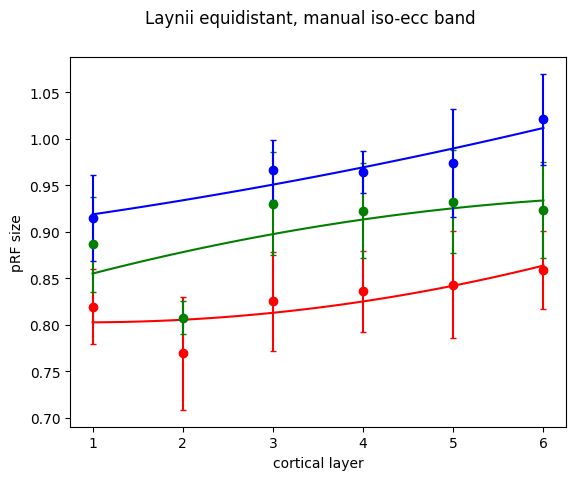

In [63]:
for roi_id in range(0,len(roi_list)):       
    idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[0]) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
    #depth    = depth[1:]
    pRF_2deg = np.empty((len(depth),len(subject_list)))

    for sub_id in range(0,len(subject_list)):
        idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                            (df_pRFxecc_stats_equidist_2ecc['depth'] >= np.min(depth)) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values


    # omit nans
    idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
    pRF_2deg = pRF_2deg[idx,:]
    depth=depth[idx]

    # Transform the independent variable into a set of polynomial features
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(depth.reshape(-1,1))

    # Create and fit the model
    model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

    # Make predictions
    X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)

    y_mean = y_plot.mean(axis=1)
    y_median = np.median(y_plot,axis=1)


    # data for plot
    depth_plot    = df_pRFxecc_stats_equidist_2ecc.loc[:,'depth'].values
    pRF_2deg_plot = df_pRFxecc_stats_equidist_2ecc.loc[:,'pRF@2deg'].values


    # plot
    if roi_id == 0:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='ro')
        plt.plot(X_plot,y_mean,'r-')
    elif roi_id == 1:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='go')
        plt.plot(X_plot,y_mean,'g-')
    elif roi_id == 2:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='bo')
        plt.plot(X_plot,y_mean,'b-')
   
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.suptitle('Laynii equidistant, manual iso-ecc band')
plt.show()


### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Set number of layers, eccentricities, subjects, hemispheres

In [90]:
n_layers   = 6
n_rois     = 3
n_sub      = len(subject_list)
n_hem      = len(hem_list)

Thresholds

In [91]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

In [92]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [93]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol_2ecc = pd.DataFrame({
    'sub id' : subs,
    'roi' : rois,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [94]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        for roi_id in range(0,len(roi_list)):
            # lh
            idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                        (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # rh
            idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                        (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

    #         y_sigma = lh_sigma
    #         x_ecc = lh_ecc
    #         r2 = lh_rsq

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]

            # bin eccentricity data
            bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            x_ecc=np.digitize(x_ecc,bins=bins)

        #     # random shuffle
        #     shuffle_indices = np.random.permutation(len(y_sigma))
        #     y_sigma = y_sigma[shuffle_indices]
        #     x_ecc = x_ecc[shuffle_indices]

            if len(y_sigma) < 30:
                idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
                df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
                continue


            # get pRF estimate at 2deg
            pRF_est = np.mean(y_sigma)
            #pRF_est = np.median(y_sigma)


            # save stats to df
            idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()

            df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])

    

In [95]:
df_pRFxecc_stats_equivol_2ecc.head()


sub id roi  depth  pRF@2deg
0  sub-01  V1    1.0  0.706442
1  sub-01  V1    2.0  0.685138
2  sub-01  V1    3.0  0.698426
3  sub-01  V1    4.0  0.706188
4  sub-01  V1    5.0  0.707224

#### Plot estimated pRF size at target eccentricity

[ 0.0050079  -0.02645927  0.72585881]
R2 quadratic: 0.8807470715697404
R2 linear: 0.5108569443537061
[-0.00280234  0.02472249  0.74405534]
R2 quadratic: 0.9466753654116913
R2 linear: 0.5763369331471162
[-0.0070233   0.05508655  0.81624953]
R2 quadratic: 0.5294535073374551
R2 linear: 0.1357004185531594
[ 0.00848638 -0.05647604  0.89880818]
R2 quadratic: 0.32611996191446657
R2 linear: 0.017243191939612768
[-0.00689245  0.04478645  0.93247504]
R2 quadratic: 0.6981269812183754
R2 linear: 0.0737813327562793
[ 0.00569303 -0.01360039  1.02586724]
R2 quadratic: 0.7962481281259801
R2 linear: 0.7103966839791441
[8.30031823e-04 1.66453698e-02 8.50317459e-01]
R2 quadratic: 0.9360161655819182
R2 linear: 0.9332958549215359
[-8.43180175e-04  2.79571865e-02  8.99693131e-01]
R2 quadratic: 0.30605406961697457
R2 linear: 0.3051027325672334
[-0.00666447  0.08378522  0.72899895]
R2 quadratic: 0.9250914041431222
R2 linear: 0.85847155071982
[-0.00159854  0.03137653  0.75794112]
R2 quadratic: 0.59183543954345

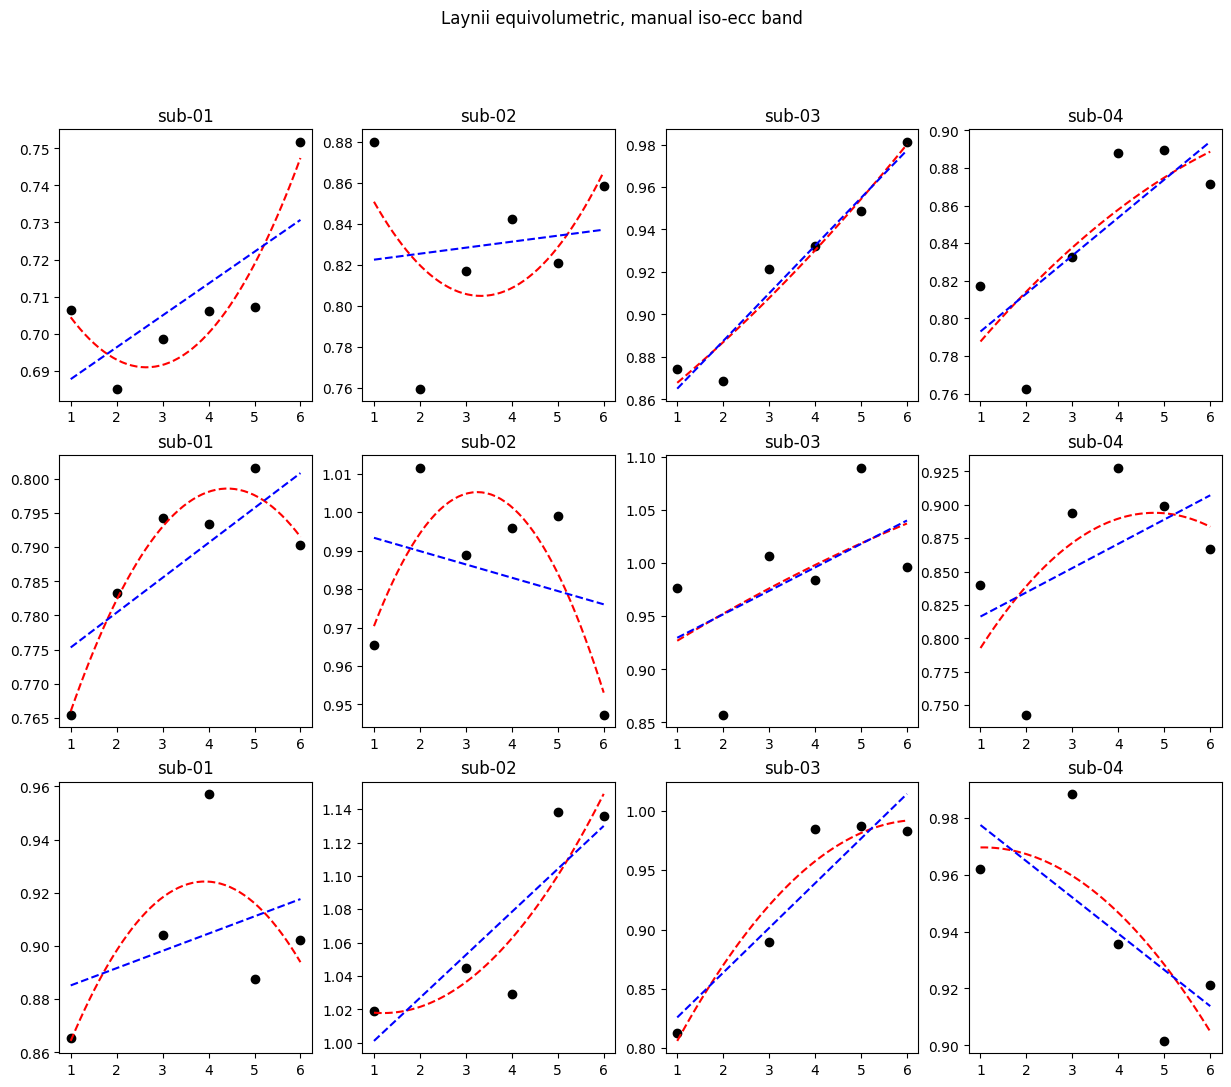

In [96]:
fig, axs = plt.subplots(nrows=len(roi_list), ncols=len(subject_list), figsize=(15, 12))

for sub_id in range(0,len(subject_list)):
    for roi_id in range(0,len(roi_list)):
        idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
        pRF_2deg = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values

        # omit nans
        idx = np.isfinite(pRF_2deg)
        pRF_2deg = pRF_2deg[idx]
        depth=depth[idx]

        # Fit the quadratic equation
        coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

        # Fit the linear equation
        coefs_linear = np.polyfit(depth, pRF_2deg, 1)

        # Print the coefficients
        print(coefs_quadratic)

        # Create a polynomial function from the coefficients
        f_quadratic = np.poly1d(coefs_quadratic)
        f_linear = np.poly1d(coefs_linear)

        # calculate the R-squared
        r_squared = r2_score(pRF_2deg, f_quadratic(depth))
        print(f"R2 quadratic: {r_squared}")
        r_squared = r2_score(pRF_2deg, f_linear(depth))
        print(f"R2 linear: {r_squared}")

        # quadratic model fit
        #x = np.linspace(0.2, 0.9, 50)
        x = np.linspace(1, n_layers, 50)
        y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
        y_linear = coefs_linear[0]*x + coefs_linear[1]

        # plot the model
        axs[roi_id,sub_id].plot(depth,pRF_2deg,'ko')
        axs[roi_id,sub_id].plot(x,y_quadratic,'r--')
        axs[roi_id,sub_id].plot(x,y_linear,'b--')
        if sub_id == 0 & roi_id == len(roi_list)-1:
            axs[roi_id,sub_id].set_xlabel('cortical layer')
            axs[roi_id,sub_id].set_ylabel('pRF size')
        axs[roi_id,sub_id].set_title(subject_list[sub_id])
    #     axs[sub_id].set_ylim([0.65, 1.15])
    #     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6)) 
#         axs[roi_id,sub_id].set_ylim([0.6, 1.1])
#         axs[roi_id,sub_id].set_yticks(np.linspace(0.6,1.1,6)) 
    

plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equivol_2ecc.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

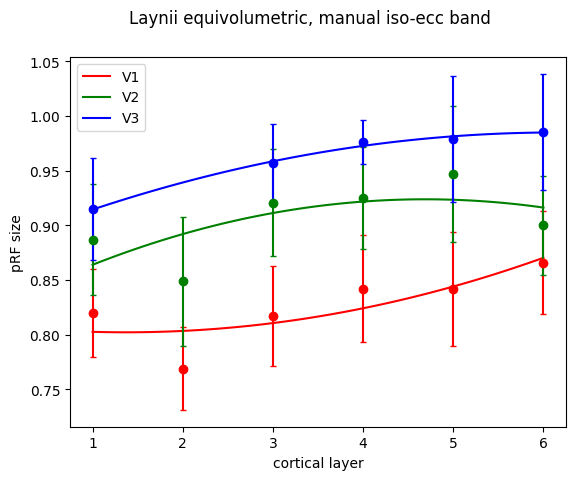

In [101]:
for roi_id in range(0,len(roi_list)):       
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[0]) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
    #depth    = depth[1:]
    pRF_2deg = np.empty((len(depth),len(subject_list)))

    for sub_id in range(0,len(subject_list)):
        idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                            (df_pRFxecc_stats_equivol_2ecc['depth'] >= np.min(depth)) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values


    # omit nans
    idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
    pRF_2deg = pRF_2deg[idx,:]
    depth=depth[idx]

    # Transform the independent variable into a set of polynomial features
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(depth.reshape(-1,1))

    # Create and fit the model
    model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

    # Make predictions
    X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)

    y_mean = y_plot.mean(axis=1)
    y_median = np.median(y_plot,axis=1)


    # data for plot
    depth_plot    = df_pRFxecc_stats_equivol_2ecc.loc[:,'depth'].values
    pRF_2deg_plot = df_pRFxecc_stats_equivol_2ecc.loc[:,'pRF@2deg'].values


    # plot
    if roi_id == 0:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='ro')
        line1=plt.plot(X_plot,y_mean,'r-')
    elif roi_id == 1:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='go')
        line2=plt.plot(X_plot,y_mean,'g-')
    elif roi_id == 2:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='bo')
        line3=plt.plot(X_plot,y_mean,'b-')
        
   
plt.legend(['V1', 'V2', 'V3'])

plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()


# Pooling and max prob of fitted distribution

Set number of layers, eccentricities, subjects, hemispheres

In [114]:
n_layers   = 6
n_sub      = len(subject_list)
n_hem      = len(hem_list)
n_rois     = 3

Thresholds

In [115]:
rsq_thresh = 0.1
target_ecc = 2
pRF_thresh = max_ecc_deg

In [116]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth  = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))

cortdist = np.empty((1,len(subs),)).tolist()
cortdist = list(itertools.chain(*cortdist))


df_pRF_filtered_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'roi' : rois,
    'pRFs': pRF_2deg,
    'cortdist': cortdist
})

In [117]:
for roi_id in range(0,len(roi_list)):  
    for depth_idx in depth:
        for sub_id in range(0,len(subject_list)):
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            print(subject_list[sub_id])
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            # lh
            idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                         (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
            lh_cortdist = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'cortdist'].to_numpy(), axis=0)

            # rh
            idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                                (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
            rh_cortdist = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'cortdist'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))
            cortdist = np.concatenate((lh_cortdist.T,rh_cortdist.T))

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
            cortdist = np.atleast_2d(cortdist[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            cortdist    = np.atleast_2d(cortdist[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            cortdist = np.atleast_2d(cortdist[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]
            cortdist           = cortdist[idx_or,:]

            print('Nr voxels at layer '+str(depth_idx)+': '+str(len(y_sigma)))


             # save stats to df
            idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                    (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                    (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()

            df_pRF_filtered_equivol.loc[idx, 'pRFs'] = pd.Series([y_sigma], index=df_pRF_filtered_equivol.index[idx])
            df_pRF_filtered_equivol.loc[idx, 'cortdist'] = pd.Series([cortdist], index=df_pRF_filtered_equivol.index[idx])
        

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 1853
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 1355
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 837
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 1681
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 41
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%

Nr voxels at layer 5.0: 508
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 5.0: 406
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 5.0: 384
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 6.0: 263
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 6.0: 356
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 6.0: 183
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [118]:
df_pRF_filtered_equivol.head()

sub id  depth roi                                               pRFs  \
0  sub-01    1.0  V1  [[1.530799371375438], [0.49762651903208505], [...   
1  sub-01    2.0  V1  [[0.39990071754897566], [0.5922531331289524], ...   
2  sub-01    3.0  V1  [[0.41297039532836194], [0.39505644227768305],...   
3  sub-01    4.0  V1  [[0.9463248873475711], [0.8219629342293395], [...   
4  sub-01    5.0  V1  [[0.5942778238262738], [0.4111170042621683], [...   

                                            cortdist  
0  [[-0.8], [-0.8], [-0.8], [-0.8], [-0.8], [-0.8...  
1  [[0.8], [0.8], [0.8], [0.8], [0.8], [0.8], [0....  
2  [[1.1313708498984762], [0.8], [0.8], [0.8], [0...  
3  [[1.6], [0.8], [1.6], [1.3856406460551018], [1...  
4  [[1.6], [1.6], [1.6], [1.6], [1.38564064605510...

In [119]:
V1_all_sigma_list = []
V1_all_pos_list = []
V1_cortdist_list = []
roi_id = 0

for depth_idx in depth:
    sigmas_thisdepth = []
    cortdist_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                        (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        cortdist_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'cortdist'].values[0])
    V1_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    V1_all_pos_list.append(depth_idx)
    V1_cortdist_list.append(np.array(flatten(cortdist_thisdepth)))
    
    
V2_all_sigma_list = []
V2_all_pos_list = []
V2_cortdist_list = []
roi_id = 1

for depth_idx in depth:
    sigmas_thisdepth = []
    cortdist_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                        (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        cortdist_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'cortdist'].values[0])
    V2_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    V2_all_pos_list.append(depth_idx)
    V2_cortdist_list.append(np.array(flatten(cortdist_thisdepth)))

V3_all_sigma_list = []
V3_all_pos_list = []
V3_cortdist_list = []
roi_id = 2

for depth_idx in depth:
    sigmas_thisdepth = []
    cortdist_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                        (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        cortdist_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'cortdist'].values[0])
    V3_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    V3_all_pos_list.append(depth_idx)
    V3_cortdist_list.append(np.array(flatten(cortdist_thisdepth)))

## Bootstrapping

In [ ]:
# non-parametric fit parameters
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

# Set the number of bootstrap samples, depths
n_boot = 1000
n_depth = len(depth)


# Create an array to store the maximum probability values
V1_maxprobs = np.zeros([n_depth,n_boot])
V2_maxprobs = np.zeros([n_depth,n_boot])
V3_maxprobs = np.zeros([n_depth,n_boot])


# Generate bootstrap samples and calculate the maximum probability value for each sample
# V1
pRFsizes = V1_all_sigma_list

for n in range(0,len(depth)):
        data = np.squeeze(pRFsizes[n])

        for i in range(n_boot):
            sample = np.random.choice(data, size=len(data), replace=True)
    
            dens = sm.nonparametric.KDEUnivariate(sample)
            dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

            s = dens.support
            idx = np.argmax(dens.density)
            V1_maxprobs[n,i] = s[idx]

# V2
pRFsizes = V2_all_sigma_list

for n in range(0,len(depth)):
        data = np.squeeze(pRFsizes[n])

        for i in range(n_boot):
            sample = np.random.choice(data, size=len(data), replace=True)
    
            dens = sm.nonparametric.KDEUnivariate(sample)
            dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

            s = dens.support
            idx = np.argmax(dens.density)
            V2_maxprobs[n,i] = s[idx]

# V3
pRFsizes = V3_all_sigma_list

for n in range(0,len(depth)):
        data = np.squeeze(pRFsizes[n])

        for i in range(n_boot):
            sample = np.random.choice(data, size=len(data), replace=True)
    
            dens = sm.nonparametric.KDEUnivariate(sample)
            dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

            s = dens.support
            idx = np.argmax(dens.density)
            V3_maxprobs[n,i] = s[idx]


In [139]:
# Calculate the lower and upper bounds of the confidence interval
ci_lower = np.percentile(V1_maxprobs[0,:], 2.5)
ci_upper = np.percentile(V1_maxprobs[0,:], 97.5)

In [141]:
ci_upper

0.573993903347141

## V1

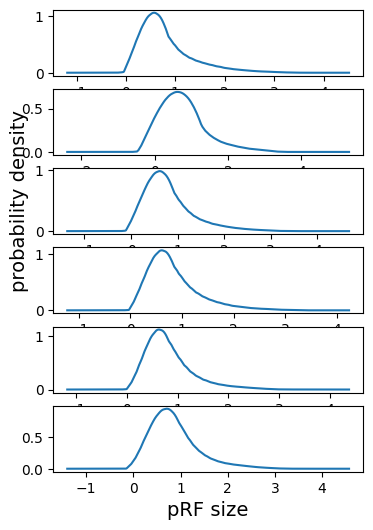

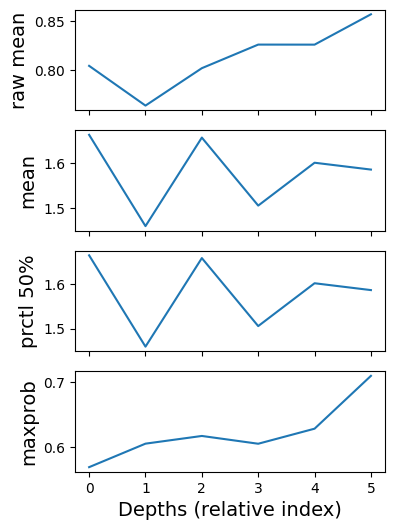

In [120]:
pRFsizes = V1_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V1_sigmas=sigmas

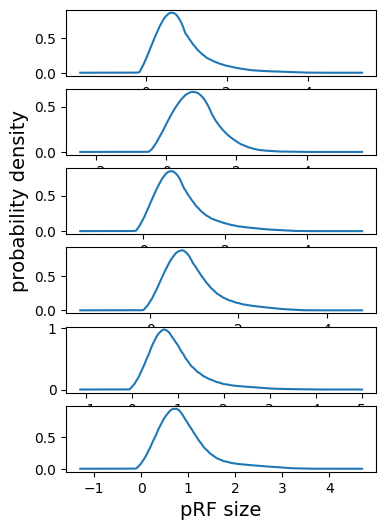

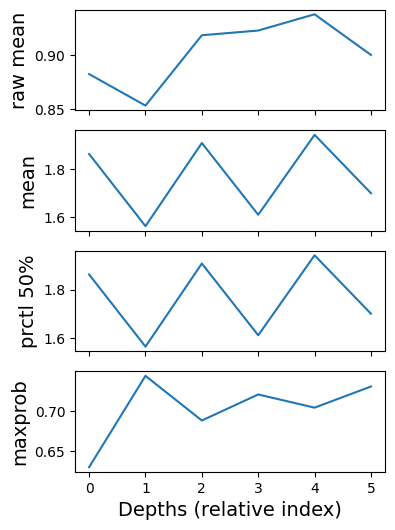

In [121]:
pRFsizes = V2_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V2_sigmas=sigmas

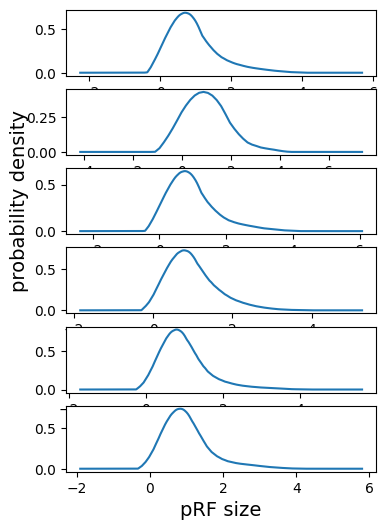

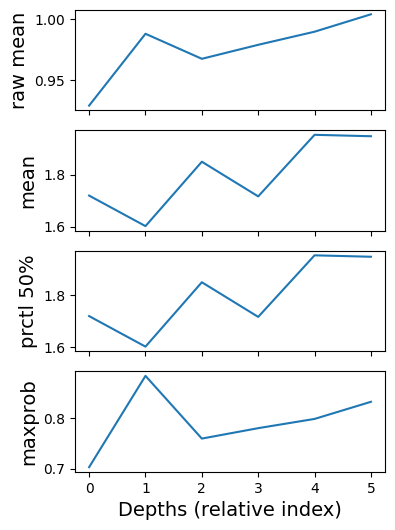

In [122]:
pRFsizes = V3_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V3_sigmas=sigmas

Text(0.5, 0, 'Depths (relative index)')

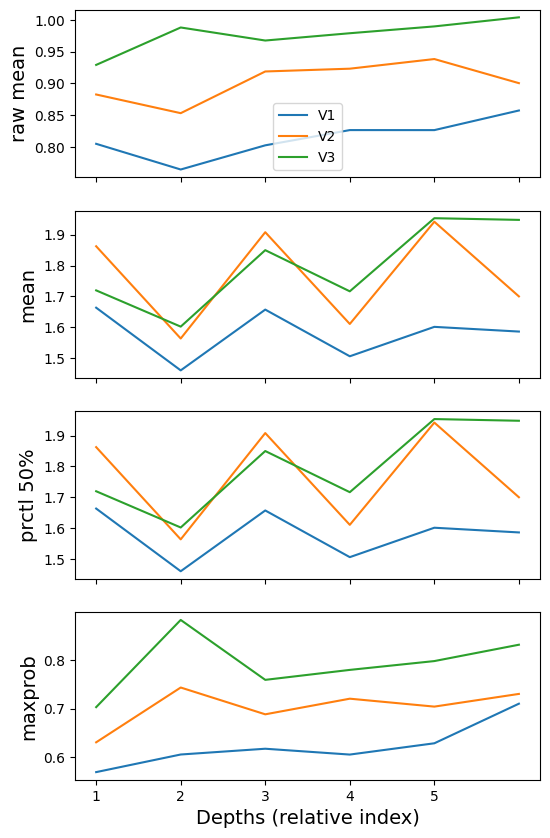

In [123]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(6, 10))
for n in range(4):
    ax[n].plot(V1_sigmas[:,n])
    ax[n].plot(V2_sigmas[:,n])
    ax[n].plot(V3_sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
    else:
        ax[n].set_xticks([0,1,2,3,4])
        ax[n].set_xticklabels([1,2,3,4,5])
    if n == 0 :
        ax[n].legend(['V1','V2','V3'])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)


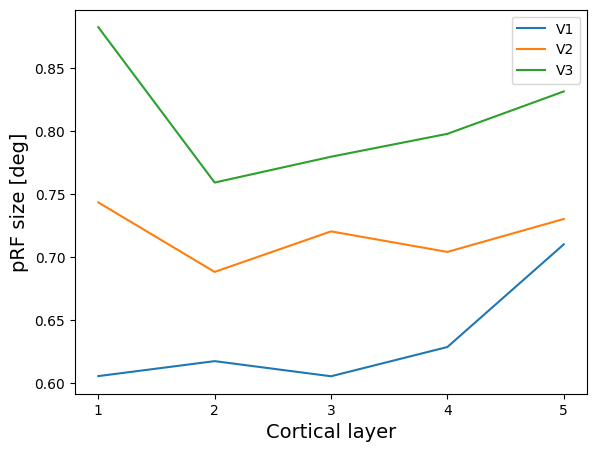

In [127]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

n = 3 #only plot max prob
use_cortdist=False

if use_cortdist:
    x_V1 = [np.mean(V1_cortdist_list[1]),
     np.mean(V1_cortdist_list[2]),
     np.mean(V1_cortdist_list[3]),
     np.mean(V1_cortdist_list[4]),
     np.mean(V1_cortdist_list[5])]
    x_V2 = [np.mean(V2_cortdist_list[1]),
     np.mean(V2_cortdist_list[2]),
     np.mean(V2_cortdist_list[3]),
     np.mean(V2_cortdist_list[4]),
     np.mean(V2_cortdist_list[5])]
    x_V3 = [np.mean(V3_cortdist_list[1]),
     np.mean(V3_cortdist_list[2]),
     np.mean(V3_cortdist_list[3]),
     np.mean(V3_cortdist_list[4]),
     np.mean(V3_cortdist_list[5])]
    ax.plot(x_V1,V1_sigmas[1:,n])
    ax.plot(x_V2,V2_sigmas[1:,n])
    ax.plot(x_V3,V3_sigmas[1:,n])
    ax.set_xticks(np.linspace(round(np.min(np.unique(np.array(x_V1+x_V2+x_V3))),1),
                          round(np.max(np.unique(np.array(x_V1+x_V2+x_V3))),1),5))
    ax.set_xlabel('Cortical depth [mm]', fontsize=14)
else:
    ax.plot(V1_sigmas[1:,n])
    ax.plot(V2_sigmas[1:,n])
    ax.plot(V3_sigmas[1:,n])
    
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels([1,2,3,4,5])
    ax.set_xlabel('Cortical layer', fontsize=14)
ax.set_ylabel('pRF size [deg]', rotation=90, fontsize=14)




ax.legend(['V1','V2','V3'])
